# 0 - Package Initialization

In [1]:
#Python version used: 3.9.12
#Packages necessary to construct a kinase network from the user uploaded file
import pandas as pd
import networkx as nx
from networkx import *
import csv
import itertools
from itertools import chain
import numpy as np
from scipy.stats import norm
import statistics
from statistics import *
import operator
import functools
#Visualizations
import plotly.express as px
import plotly.graph_objects as go 
#from pyvis.network import Network
import matplotlib as mpl
import matplotlib.colors as mcolors
#Community detection
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sknetwork.clustering import Louvain
#Data manipulation
import collections
from collections import ChainMap
from collections import OrderedDict
import BioVenn
from BioVenn import draw_venn
import re
from itertools import chain,combinations
from funcy import join_with

# 1 - Functions

## 1.1 - Extracting information from a z-scores dataset

In [2]:
# input: dataset must be a csv files in which the first column is the kinase interactions (pairs), and each following 
# column the z-scores of each of the kinase interactions in one of the treatments
# output: treatments are the headers of each of the z-scores columns, used to name visulizations returned from the analysis
# negative_edges is a list of lists, each list corresponding to a treatment in the dataset, it's contents being the 
# kinase interactions in said treatment with a z_score <0 and their z_scores,in the shape of tuples, i.e. a network
# negative_nodes is a list of lists, each list corresponding to the kinases of one network
def dataset_info(dataset, rem_vs_control='no', sign = 'neg'):
    # Read dataset and drop rows with no z-score information
    networkfile = pd.read_csv(dataset)
    networkfile = networkfile.dropna()
    
    # Return the headers of the z_scores columns, i.e. the treatments names
    headers = list(networkfile.columns.values)[1:]
    treatments = [x.split(".")[-1] for x in headers]
    if rem_vs_control == 'yes':
        treatments = [x.split("_")[0] for x in treatments]
    
    # Convert first column (kinase interactions/pairs) of the document to a list
    edges_list= networkfile[networkfile.columns[0]].to_list()
    # Convert the list into a list of tuples, each tuple being one kinase pair/edge (since this is the format needed to 
    # add edges onto pyvis.network (network visualization package))
    edges_list2 = [tuple(x.split('.',1)) for x in edges_list]
    
    #For each treatment(column) on the file, store kinase interactions/pairs with a z-score <0 or >0, and their z-scores
    headers_in = range(1,len(headers))
    if not headers_in:
        headers_in = [1]
    if sign == 'neg':
        #Note that z-scores are converted to positive values for community detection
        edges = [[(*edges_list2[n],+ abs(networkfile[networkfile.columns[na]].to_list()[n])) for n in range(len(edges_list2)) if networkfile[networkfile.columns[na]].to_list()[n] < 0 ] for na in headers_in]
    elif sign == 'pos' :
        edges = [[(*edges_list2[n],+ networkfile[networkfile.columns[na]].to_list()[n]) for n in range(len(edges_list2)) if networkfile[networkfile.columns[na]].to_list()[n] > 0 ] for na in headers_in]
    
    #negativenetwork.add_weighted_edges_from(edges_list)
    
    #Kinases in each of the negative_edges lists
    nodes = []
    for selected_treatment in edges:
        #Keep only the kinases names (i.e. remove the z-scores) from the list of edges
        nodes_bf = [ (a,b) for a,b,c in selected_treatment]
        #Flatten list of edges tuples to list of nodes
        nodes = list(itertools.chain(*nodes_bf))
        #Remove duplicates from the list
        nodes_list = list(dict.fromkeys(nodes))
        nodes.append(nodes_list)
    
    #Convert edges and nodes list of lists into dictionary
    edges = dict(zip(treatments,edges))
    nodes = dict(zip(treatments,nodes))
    
    return treatments,edges,nodes


## 1.2 - Community detection

In [ ]:
# 1. Are all the final runs the same?

In [3]:
# input: edges_list is a list corresponding to a treatment in the dataset, it's contents being the kinase interactions
# in said treatment with a z_score <0 and their z_scores,in the shape of tuples, i.e. a network 
# output: A_asso is the converged association matrix, n_iter the number of iterations required for convergence and 
# labels are the converged community labels 
def converge_asso(edges_dict, sel_treatments='all'):
    
    #If no selected treatments are specified, the keys of the edges dictionary are taken as treatments
    if sel_treatments=='all':
        sel_treatments = edges_dict.keys()
    #Dictionaries with selected treatments as keys
    communities_list = dict.fromkeys(sel_treatments)
    communities_nx = dict.fromkeys(sel_treatments)
    communities_cs = dict.fromkeys(sel_treatments)

    for treatment in sel_treatments:
        #Initialize a Networkx instance
        negativenetwork = nx.Graph()
        #Add the kinase interactions & z-scores of treatment w to the network
        edges_list = edges_dict[treatment]
        negativenetwork.add_weighted_edges_from(edges_list)
        #Store the individual kinases in the network as a numpy array - to return kinases in each community at the end
        node_0 = list(negativenetwork.nodes())
        node_0_arr = np.asarray(node_0)
        #A_0 is the adjacency matrix of the matrix (network instance) stored as a numpy array
        A_0 = to_numpy_array(negativenetwork)
    
        n_runs = 100
        A_runs = np.zeros((n_runs, len(A_0)))
        #Run the community detection algorithm on the network A_0 an n_runs amount of times
        for i in range(n_runs):
            #Louvain algorithm with Potts null network
            louvain = Louvain(1, 'potts', shuffle_nodes = 1)
            #Communities identified by number (Community 1, Community 2...)
            #Array is the length of the number of kinases in the network
            #For each kinase, it's community assignement is indicated by number
            labels = louvain.fit_transform(A_0)
            #Store the community partitions of each run
            A_runs[i,:] = labels

        #X = Number of kinases in the network
        #Create & store 'X' arrays of 'X' zeros each
        A_asso = np.zeros((len(A_0), len(A_0)))
        #After loop, each array corresponds to one kinase, and each position within an array indicates in how many runs that kinase is
        #assigned to the same community as each of the kinases in the network 
        #Loop over each run
        for i in range(n_runs):
            #Loop over each kinase/node in network (identified by number)
            for j in range(len(A_0)):
                #Loop over each kinase/node in network (identified by number)
                for l in range(len(A_0)):
                #If j and l are assigned to the same community in run i, add '1' to position l of array j   
                    A_asso[j,l] = A_asso[j,l] + (A_runs[i,j] == A_runs[i,l])
    
        #Divide each element in each of the arrays in the converged association matrix(A_asso) by n_runs to get
        #the percentage (in 0.1(=10%) format) of runs in which each kinase-kinase/node-node combination is assigned to the same community
        A_asso = np.true_divide(A_asso, n_runs)
    
        n_iter = 0
        #until all the entries in A_asso are 0(not grouped together) or 1(grouped together) (all runs are the same)
        while(len(np.unique(A_asso)) != 2):
            n_runs = 100
            #Create an array for each run, the length of each array being the number of kinases in the network
            A_runs = np.zeros((n_runs, len(A_0)))
            #Repeat community detection on co-classification matrix (the weight of the edges is the percentage of runs in which two kinases are grouped together)
            for i in range(n_runs):
                louvain = Louvain(1, 'potts', shuffle_nodes = 1)
                labels = louvain.fit_transform(A_asso)
                A_runs[i,:] = labels
            A_asso = np.zeros((len(A_0), len(A_0)))
            for i in range(n_runs):
                for j in range(len(A_0)):
                    for l in range(len(A_0)):
                        A_asso[j,l] = A_asso[j,l] + (A_runs[i,j] == A_runs[i,l])
            #Return percentage of runs in which each kinase-kinase combination is a ssigned to the same community
            A_asso = np.true_divide(A_asso, n_runs)
            n_iter = n_iter + 1 
    
        #Final community partitions (all runs are the same)
        labels = A_runs[0,:]
    
        #find how many communities are identified
        n_of_com = list(set(labels.flatten()))

        #List of communities of kinases as lists
        communities_list[treatment] = [list(itertools.chain(*node_0_arr[np.argwhere(labels == int(n))])) for n in n_of_com]
        #Dictionaries of communities as networkx instances
        communities = [dict.fromkeys(com,negativenetwork.subgraph(com)) for com in communities_list[treatment]]
        communities_nx[treatment] = dict(ChainMap(*communities))
        #Dictionaries of each kinase community strength
        communities_cs[treatment] = {k:v.degree([k],weight='weight')[k] for k,v in communities_nx[treatment].items()}
        
        #Add kinase community strength as attribute to nodes in the networkx dictionnaries
        for com in communities_list[treatment]:
            #Select the community strength of kinases in this community
            com_cs_dict = {kin:communities_cs[treatment][kin] for kin in com}
            #Set as node attributes in community nx instance of these kinases
            for kin in com:
                nx.set_node_attributes(communities_nx[treatment][kin], com_cs_dict, "community_strength_centrality")
    
    #Return dictionaries
    return communities_list, communities_nx, communities_cs


## 1.3 - Reproducibility check

In [276]:
#Run converge_asso an n_checks number of times and check if the contents of the community of interest differ
def rep_check(n_checks, edges_dict, treatment, target):
    
    ##Run converge_asso n_checks times and store the contents of the identified communities each time
    all_runs_list = ['a'] * n_checks
    all_runs_nx = ['a'] * n_checks
    for n in range(n_checks):
        [all_runs_list[n],all_runs_nx[n],cs] = converge_asso(edges_dict, sel_treatments=[treatment])
  
    ##Check if there are any kinases that are not present in all the community versions
    all_runs_target_community = [ [com for com in all_runs_list[n][treatment] if target in com] for n in range(n_checks)]
    all_com = list(itertools.chain(*itertools.chain(*all_runs_target_community)))
    target_community_rem = [x for x in list(set(all_com)) if all_com.count(x)==n_checks]
    
    ##Change list of communities and dictionary on networkx instances accordingly
    
    #List
    communities_list_rem= [target_community_rem if target in com else com for com in all_runs_list[0][treatment]]
    
    #NX instances dictionary
    all_runs_nx_sel = all_runs_nx[0][treatment]
    #
    #Update remaining kinases
    community_as_nx = all_runs_nx_sel[target].subgraph(target_community_rem)
    communities_nx_rem = dict(all_runs_nx_sel, **dict.fromkeys(target_community_rem, community_as_nx))
    #
    #Assign kinases not present from all runs to X_removed
    kin_del= [kin for kin in all_runs_nx_sel[target] if kin not in target_community_rem]
    communities_nx_rem_del = dict(communities_nx_rem, **dict.fromkeys(kin_del, f"{target}<{n_checks}"))
    communities_nx_rem_del[f"{target}<{n_checks}"] = kin_del
    
    #CS dictionary
    communities_cs = {k:v.degree([k],weight='weight')[k] for k,v in communities_nx_rem.items()}
    
    #Add CS to nx instances
    for k in communities_nx_rem.keys():
        if type(communities_nx_rem_del[k]) != str:
            nx.set_node_attributes(communities_nx_rem_del[k], communities_cs, "community_strength_centrality")
        
    
    return communities_list_rem, communities_nx_rem_del, communities_cs


## 1.4 - Comparisson of CS across communities visualized in heatmap

In [366]:
# input: edges_list is a list corresponding to a treatment in the dataset, it's contents being the kinase interactions
# in said treatment with a z_score <0 and their z_scores,in the shape of tuples, i.e. a network
# community is a list of the kinases in the community of interest
# output: dictionary of kinases and their community strength
def cs_comparisson(communities_nx, communities_cs, treatment_targets_sign, kin_int=None, position=0):
    #Calculate the community strength of each of the kinases in the two selected communities you are comparing
    #kin_cs = ['a'] * len(treat_int)
    #for n in range(len(treat_int)):
        #na = treat_int[n]
        # Store kinase pairs in which both kinases are in the community of interest
        #community_edges = [x for x in edges[na] if x[0] in communities[na] and x[1] in communities[na]]
        # Calculate the community strength of each of the kinases in the community and store as dictionary
        #kin_cs[n] = {kin:abs(round(sum([community_edges[n][2] for n in range(len(community_edges)) if community_edges[n][1]==kin or community_edges[n][0]==kin]), 2)) for kin in communities[na]}    

    #Specify which kinases you want to get the values of
    if kin_int == None:
        #Combine two communities lists
        kinases = set(itertools.chain(*[list(communities_nx[x[0]][x[1]] ) for x in treatment_targets_sign]))
    else:
        kinases = kin_int
    
    #Get values for each of the kinases in the combined list in each of the communities
    values = [ [communities_cs[x[0]][kin] if kin in list(communities_nx[x[0]][x[1]]) else None for kin in kinases] for x in treatment_targets_sign ]
    
    #Define heatmap axis and text
    x = list(kinases)
    #<sub></sub> for subscript, <sup></sup>
    y = [ f"{x[0]}<sup>{x[2]}</sup><sub>({x[1]})</sub><br>absolute CSC</br>" for x in treatment_targets_sign]
    z = values#[values[0],values[1]]
    
    # HEATMAP
    fig = go.Figure(data=go.Heatmap(
                    z=z,
                    x=x,
                    y=y,
                    yaxis='y2',
                    hoverongaps = False))

    fig.update_layout(xaxis=dict(domain=[0.21,1]),
                      yaxis2=dict(anchor='free', position=position, side='right'))
    
    return fig


## Intersections and differences between specified communities

In [52]:
#def multiple_rep(dict_name, text):
  # Create a regular expression  from the dictionary keys
  #regex = re.compile("(%s)" % "|".join(map(re.escape, dict_name.keys())))

  # For each match, look-up corresponding value in dictionary
  #return regex.sub(lambda mo: dict_name[mo.string[mo.start():mo.end()]], text) 

#def int_and_diff():

# 2 - Example 1 - Analysis and Results

# Negative edges

## Specifity values of kinase inhibitors

In [396]:
import xlrd

df = pd.read_excel('/Users/cccccbbbbb/Downloads/kinase_inhibitor_selectivity.xlsm', sheet_name=None)
sheets = list(df.keys())
#DiscoverX data
dis = df[sheets[0]]
#Select inhibitors of interest
dis = dis[["kinase", "AKT...AZD5363","ERK...GDC-0994","MEK...Trametinib","PI3K...GDC-0941"]]


dis.loc[dis['kinase'] == 'MAP2K2']

dis.rename(columns={'AKT...AZD5363': 'AZD5363', 'ERK...GDC-0994': 'GDC0994','MEK...Trametinib':'Trametinib','PI3K...GDC-0941':'GDC0941'}, inplace=True)

dis


/var/folders/9d/78cj5rms6231pypdt94bp9pc0000gn/T/ipykernel_7596/1065316903.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



kinase  AZD5363  GDC0994  Trametinib  GDC0941
0     AAK1     79.0     66.0        87.0     99.0
1     ABL1     71.0     88.0        88.0      1.2
2     ABL1     81.0    100.0        83.0    100.0
3     ABL2     85.0     87.0        95.0     87.0
4    ACVR1     85.0     77.0        92.0     86.0
..     ...      ...      ...         ...      ...
401   WNK3    100.0     74.0       100.0     85.0
402   WNK4     74.0     60.0       100.0     86.0
403   YES1     88.0     89.0        85.0     93.0
404    ZAK     86.0     97.0        98.0    100.0
405  ZAP70     91.0     67.0       100.0     96.0

[406 rows x 5 columns]

## Extracting networks trametinib(-), GDC0994(-), GDC0941(-), and AZD5363(-) from edges z-score dataset

In [253]:
#Store dataset treatments names, kinase interactions (network edges) with a z-score < 0, and their z-scores (edges weight) 
[treatments, negative_edges, negative_nodes] = dataset_info('input/PROJECT_DATASET_2.csv', rem_vs_control='yes')
#Main kinase targets of each of the treatments/inhibitors in the dataset
targets = ['MAP2K1','PIK3CA','AKT1_2','MAPK1_3']

treatments

['Trametinib',
 'GDC0941',
 'AZD5363',
 'GDC0994',
 'LY2835219',
 'AZD5438',
 'CFI402257']

## Networks trametinib(-) and GDC0994(-) (MEK/ERK pathway targets)

### Community detection

In [127]:
#Please note that the following block of code takes a few minutes to run

In [277]:
#Treatments in which the main target is a MEK/ERK kinase
MEK_ERK_treatments = ['Trametinib','GDC0994']
#Run community detection on these treatments negative networks
[MEK_ERK_communities, MEK_ERK_communities_nx, MEK_ERK_cs] = converge_asso(edges_dict=negative_edges, sel_treatments=MEK_ERK_treatments)

#Because we noticed that when extracting the community of interest from the trametinib(MEK)[-] network with the converge_asso
#function the contents of said community differ from run from run, for this network we run the community detection function (converge_asso)
#50 times, and keep only the nodes that are present in the community in all 50 runs of the converge_asso function
treatment = 'Trametinib'
target = 'MAP2K1'

[MEK_ERK_communities[treatment], MEK_ERK_communities_nx[treatment], MEK_ERK_cs[treatment]] = rep_check(n_checks=50,edges_dict=negative_edges,treatment=treatment,target=target)


In [56]:
nx.get_node_attributes(MEK_ERK_communities_nx['GDC0994']['PIK3CA'], "community_strength_centrality")['PIK3CA']


2.4205706649999996

### Comparisson of community strength of communities trametinib(-)(MAP2K1) & GDC0994(-)(MAPK1_3) and visualization in heatmap

In [8]:
MEK_ERK_int = [('Trametinib','MAP2K1','-'),('GDC0994','MAPK1_3','-')]

fig = cs_comparisson(communities_nx=MEK_ERK_communities_nx, communities_cs=MEK_ERK_cs, treatment_targets_sign=MEK_ERK_int)

fig.show()


## Networks GDC0941(-) and AZD5363(-) (PI3K/AKT targets)

### Community detection

In [245]:
#Treatments in which the main target is a PIK3CA/AKT/mTOR kinase
PI3K_AKT_treatments = treatments[1:3]
#Run community detection on these treatments negative networks
[PI3K_AKT_communities, PI3K_AKT_communities_nx, PI3K_AKT_cs] = converge_asso(edges_dict=negative_edges, sel_treatments=PI3K_AKT_treatments)


### Comparisson of community strength of communities GDC0941(-)(PIK3CA) & AZD5363(-)(AKT1_2) and visualization in heatmap

In [11]:
PI3K_AKT_int = [('GDC0941','PIK3CA','-'),('AZD5363','AKT1_2','-')]

fig = cs_comparisson(communities_nx=PI3K_AKT_communities_nx, communities_cs=PI3K_AKT_cs, treatment_targets_sign=PI3K_AKT_int)

fig.show()


## Intersection and differences between communities trametinib(-)(MAP2K1), GDC0994(-)(MAPK1_3), GDC0941(-)(PIK3CA) and AZD5363(-)(AKT1_2)

In [12]:
group = com_groups_to_compare[0]

###Create communities names
com_names = [f"({x[1]}({x[0]}){x[2]})" for x in group]
    
###If comparing two communities
g = group
com1 = allcom_nx[g[0][1]][g[0][2]]
com2 = allcom_nx[g[1][1]][g[1][2]]
    
#All nodes in each community and intersection
    
com_int_and_diff = {f"{com_names[0]}_only":com1,f"{com_names[1]}_only":com2,f"{com_names[0]}{com_names[1]}":intersection(com1,com2)}
    
#Differences between communities
inter = com_int_and_diff[f"{com_names[0]}{com_names[1]}"]
com = [com1,com2]
com_int_and_diff.update({f"{com_names[n]}_only":com[n].subgraph(set(com[n].nodes()).difference(set(inter.nodes()))) for n in [0,1]})

com_int_and_diff


NameError: name 'com_groups_to_compare' is not defined

In [94]:
G = nx.path_graph(3)# or DiGraph, MultiGraph, MultiDiGraph, etc
R = nx.Graph(G)
e = nx.path_graph(2)
T = R.remove_nodes_from(e)

list(T)

TypeError: 'NoneType' object is not iterable

In [156]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    s1 = list(chain.from_iterable(combinations(s, r) for r in range(1,len(s))))
    #s2 = ["".join(x) for x in s1]
    #s2_only = [f"{x}_only" for x in s2]
    
    #s3 = list(itertools.chain(*zip(s2,s2_only)))
    return s1

#
int_and_diff = list(itertools.chain(*[ [com_names, "".join(com_names)], [f"{com}_only" for com in com_names] ]))

int_and_diff

com_groups_to_compare = [[('Trametinib','MAP2K1'),('GDC0994','MAPK1_3')],[('GDC0941','PIK3CA'),('AZD5363','AKT1_2')],[('Trametinib','MAP2K1'),('GDC0941','PIK3CA'),('AZD5363','AKT1_2')]]
group = com_groups_to_compare[2]

#All combinations
all_int = powerset(group)
#Key
#f"({x[1]}({x[0]}){x[2]})"
#Treatment
all_int[0][0][0]
#Target
all_int[0][0][1]

#int_names = [ f"({all_int[n][0][1]}({all_int[n][0][0]}){all_int[n][0][2]})" for n in range(len(all_int))]
#all_int = {}

print(int_names)
re.sub('(', '', str(all_int[3]) )


['(Trametinib(-)MAP2K1)', '(GDC0941(-)PIK3CA)', '(AZD5363(-)AKT1_2)', '(Trametinib(-)MAP2K1)', '(Trametinib(-)MAP2K1)', '(GDC0941(-)PIK3CA)']


error: missing ), unterminated subpattern at position 0

In [ ]:
nx.intersection_all

In [25]:
#Could networkx difference be useful here
#Nope, two graphs must have the same nodes
#Use intersection instead
#Unrelated, but common_neighbours could be useful for different analyses
#Finally found correct function, compose and compose_all
#Also difference and symmetric difference (nope, must have same nodes!)

#allc = [MEK_ERKallc[0],PI3K_AKTallc[0],PI3K_AKTallc[1],MEK_ERKallc[1]]
#inc = [MEK_ERKinc[0],PI3K_AKTinc[0],PI3K_AKTinc[1],MEK_ERKinc[1]]

#kinase_int = list(zip(allc,inc))

allcom_nx = dict(ChainMap(*[MEK_ERK_communities_nx, PI3K_AKT_communities_nx]))
allcom_cs = dict(ChainMap(*[MEK_ERK_cs, PI3K_AKT_cs]))

com_groups_to_compare = [[('Trametinib','MAP2K1'),('GDC0994','MAPK1_3')],[('GDC0941','PIK3CA'),('AZD5363','AKT1_2')],[('Trametinib','MAP2K1'),('GDC0941','PIK3CA'),('AZD5363','AKT1_2')]]

#R.remove_nodes_from(n for n in G if n in H)

all_int = {}
all_diff = {}
for group in com_groups_to_compare:
    
    ###Create communities names
    com_names = [f"({x[1]}({x[0]}){x[2]})" for x in group]
    
    ###Make dictionnary with all intersection and differences names
    
    
    ###If comparing two communities
    if len(group) == 2:
        g = group
        com1 = allcom_nx[g[0][1]][g[0][2]]
        com2 = allcom_nx[g[1][1]][g[1][2]]
    
        #All nodes in each community and intersection
    
        com_int_and_diff = {f"{com_names[0]}_only":com1,f"{com_names[1]}_only":com2,f"{com_names[0]}{com_names[1]}":intersection(com1,com2)}
    
        #Differences between communities
        inter = com_int_and_diff[f"{com_names[0]}{com_names[1]}"]
        com = [com1,com2]
        com_int_and_diff.update({f"{com_names[n]}_only":com[n].subgraph(set(com[n].nodes()).difference(set(inter.nodes()))) for n in [0,1]})
    
    #Intersection between all communities of interest
    #com_int = set(communities_nodes[0]).intersection(*communities_nodes)
    #Difference between each community and the intersection of all communities
    #com_diff = [set(x).difference(com_int) for x in communities_nodes]
    
    ###If comparing three communities
    #biovenn = draw_venn(list_A, list_B, list_C, subtitle="Example diagram", nrtype="abs")

    #replace = dict(zip(['x','y','z'],com_names))

    #com_int_and_diff = {multiple_rep(replace,k):v for k,v in biovenn.items()}
    
    
com_diff

[{'AKT1_2',
  'CSNK1E',
  'LATS1',
  'MAP3K1',
  'MINK1',
  'MTOR',
  'PAK1',
  'PAK3',
  'PIK3CA',
  'PIK3CB',
  'PLK1',
  'PRKACA',
  'PRKACB',
  'RPS6KA2',
  'RPS6KB1',
  'STK4',
  'TTK',
  'YES1'},
 {'ARAF', 'CDK9', 'ROCK1_2', 'SRPK3'}]

## Inferring relationship between kinase inhibitors specifity and community detection

In [491]:


#Merge all dicts
all_communities = dict(ChainMap(*[PI3K_AKT_communities,MEK_ERK_communities]))
all_communities_nx = dict(ChainMap(*[PI3K_AKT_communities_nx,MEK_ERK_communities_nx]))
all_cs = dict(ChainMap(*[PI3K_AKT_cs,MEK_ERK_cs]))
targets_dict = dict(zip(all_communities.keys(),['MAP2K1','MAPK1_3','PIK3CA','AKT1_2']))
#Separate into communities other than main and loners
all_communities_group = {k:[x for x in all_communities[k] if len(x)>2 and targets_dict[k] not in x] for k in all_communities.keys()}
all_communities_single = {k:list(itertools.chain(*[x for x in all_communities[k] if len(x)<=2])) for k in all_communities.keys()}

#Make boxplot with concentrstion after treatment for each
all_cs

{'Trametinib': {'MARK3': 0,
  'MAPKAPK2': 0,
  'ARAF': 0,
  'RPS6KA6': 0,
  'CDK7': 0,
  'MAP4K5': 0,
  'CLK1': 0.064652422,
  'CLK2': 0.064652422,
  'RPS6KA3': 0.208135782,
  'MAP3K3': 0.208135782,
  'ABL1': 0.31643741200000003,
  'LIMK1_2': 1.2319537189999998,
  'SRPK1': 1.275965688,
  'SRPK3': 0.227845709,
  'PAK1': 3.8607940010000004,
  'PAK3': 6.126496657000001,
  'PIK3CA': 5.408985050000001,
  'TTK': 3.320939876,
  'PLK1': 2.213275555,
  'PIK3CB': 2.5767544030000002,
  'LATS1': 6.000193474,
  'PRKCI': 2.362672293,
  'TNK2': 8.140235502,
  'MAP3K1': 1.7431297369999998,
  'MTOR': 7.8198558469999995,
  'YES1': 1.6917886769999997,
  'AKT1_2': 12.561649595000006,
  'PDGFRB': 1.951683537,
  'CSNK1E': 2.195431663,
  'MAP2K1': 6.845639181,
  'MAPK1_3': 2.749804777,
  'RPS6KA2': 2.8999521690000005,
  'STK3': 1.092162211,
  'PRKACA': 8.248989092999999,
  'PAK4': 1.098474277,
  'STK4': 2.206951601,
  'MINK1': 2.82550181,
  'PRKACB': 3.462570552,
  'RPS6KB1': 2.485245024,
  'CAMKK2': 5.68078

In [459]:
rat = dis[dis['kinase'].isin(['PIK3CA','AKT1'])]

for tr in all_communities_group.keys():
    #tick_names
    kinase_com = [x[0] for x in all_communities_group[tr]]
    tick_names = [targets_dict[tr]] + kinase_com + ['communities \n ≤ 2 kinases']
    #values
    #target_val = dis[dis['kinase'].isin(list(all_communities_nx[tr][targets_dict[tr]]))][tr]
    #print(target_val)
    target_replace = {'MAPK1_3':['MAPK1','MAPK3'],'AKT1_2':['AKT1','AKT2']}
    target = list(itertools.chain(*[target_replace[x] if x in target_replace.keys() else [x] for x in list(all_communities_nx[tr][targets_dict[tr]])]))
    
    
target



['SRPK1',
 'PRKACB',
 'MAP4K5',
 'PRKACA',
 'PIK3CB',
 'MAPK14',
 'LATS1',
 'CDK2',
 'MTOR',
 'TNK2',
 'PLK1',
 'MINK1',
 'CSNK1E',
 'PAK3',
 'CIT',
 'PAK1',
 'AKT1',
 'AKT2',
 'RPS6KB1',
 'PIK3CA',
 'MAPKAPK2',
 'PRKCI',
 'MAP3K1',
 'LIMK1_2',
 'ABL1',
 'TTK']

In [482]:
mean(nx.get_edge_attributes(net, 'weight').values())

mean(nx.get_node_attributes(net, 'community_strength_centrality').values())

5.039885622615385

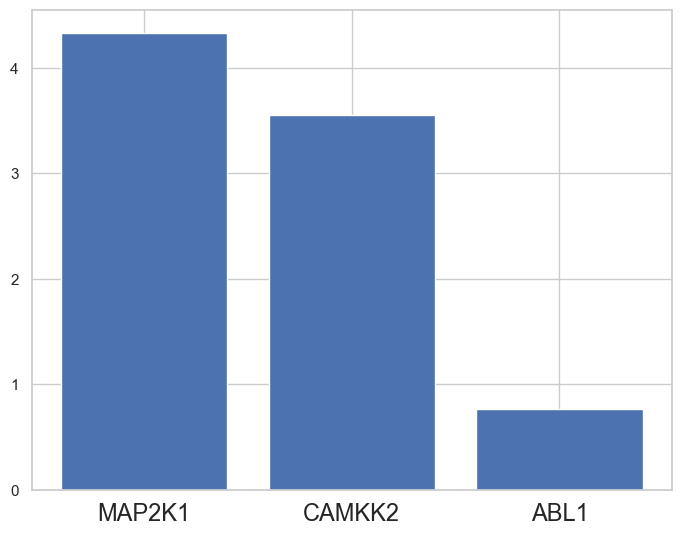

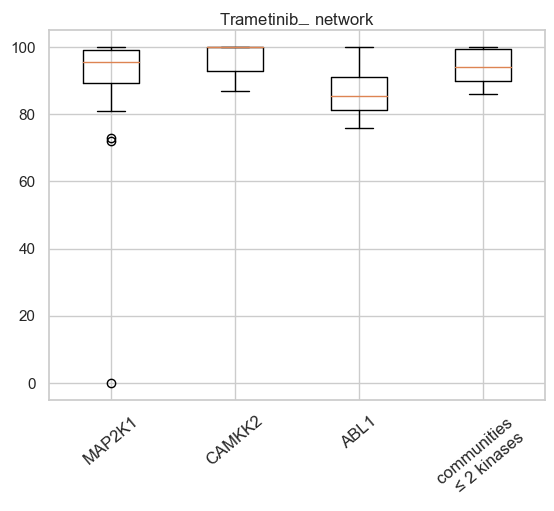

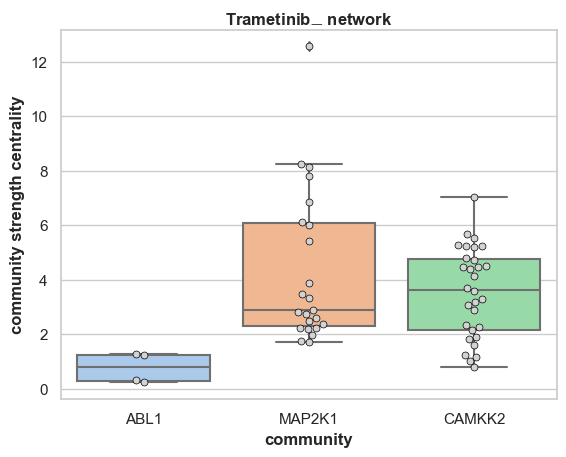

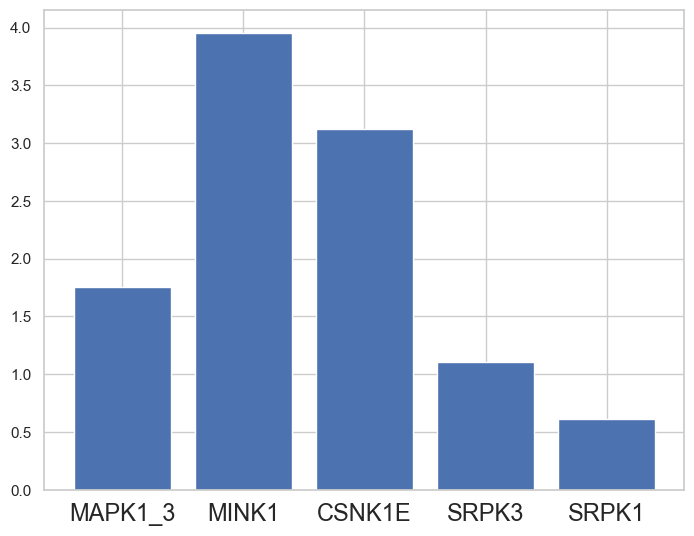

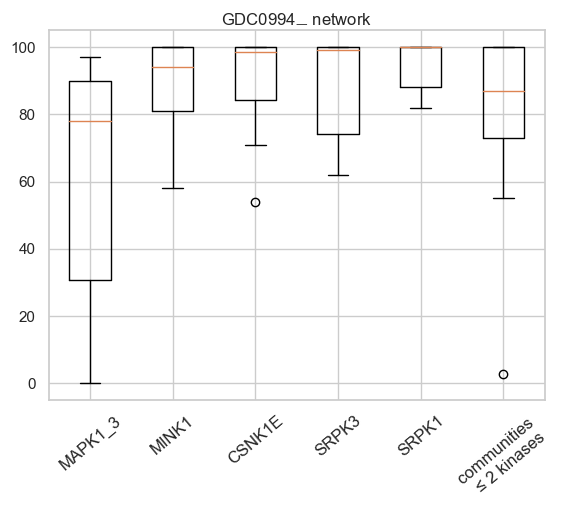

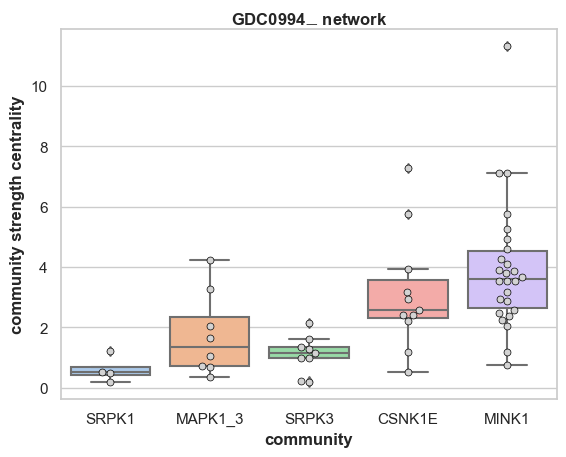

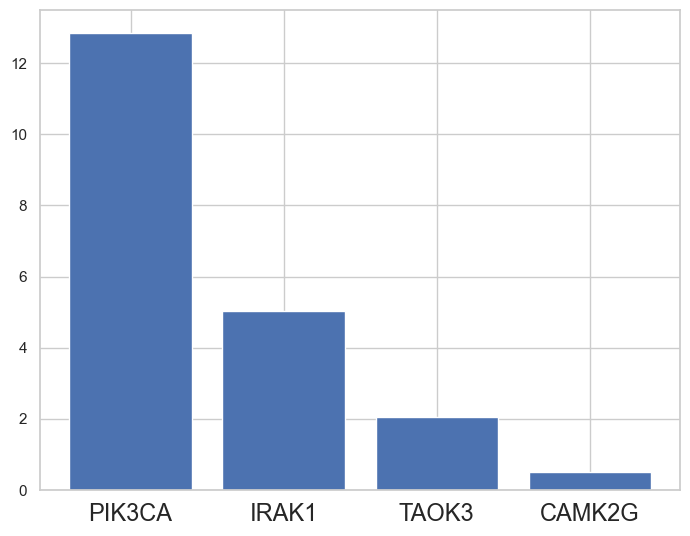

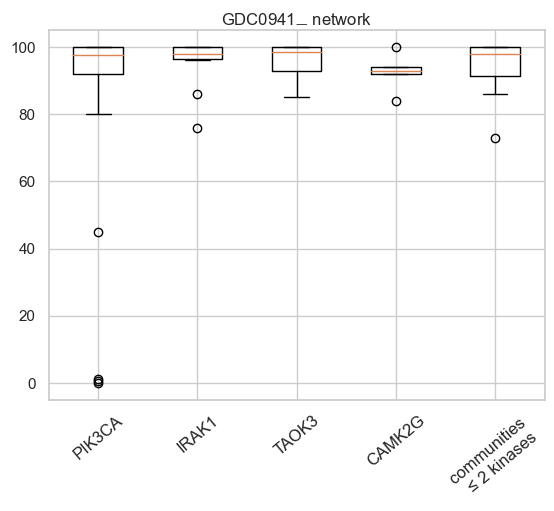

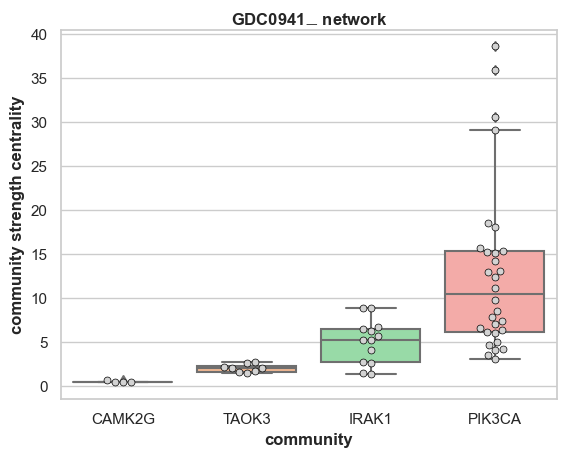

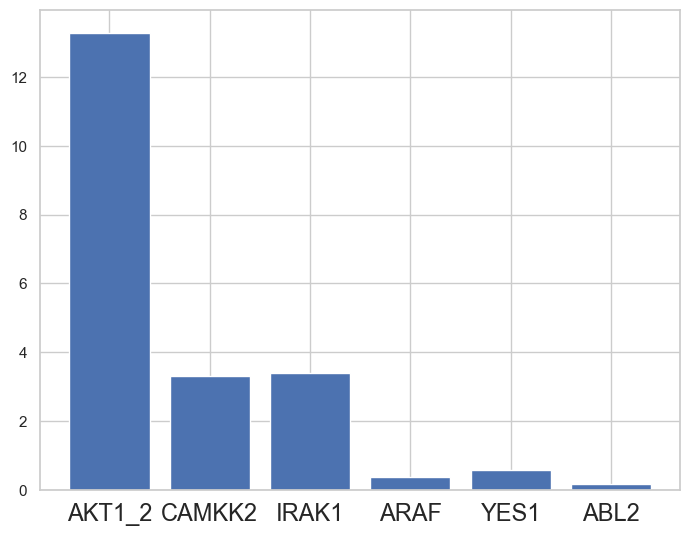

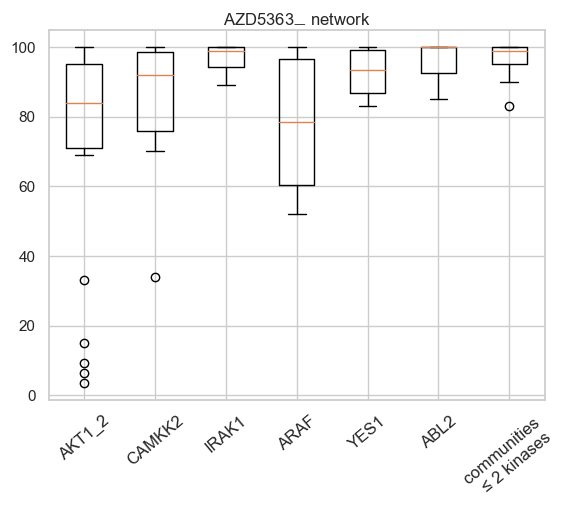

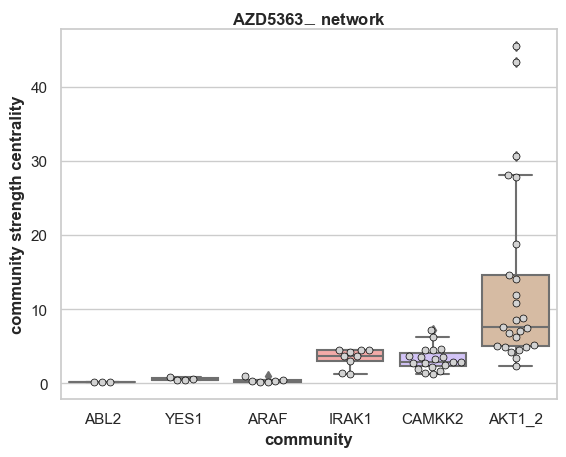

In [517]:
import seaborn as sns

for tr in all_communities_group.keys():
    #tick_names
    kinase_com = [x[0] for x in all_communities_group[tr]]
    tick_names = [targets_dict[tr]] + kinase_com + ['communities \n ≤ 2 kinases']
    #values
    #target_val = dis[dis['kinase'].isin(list(all_communities_nx[tr][targets_dict[tr]]))][tr]
    #print(target_val)
    target_replace = {'MAPK1_3':['MAPK1','MAPK3'],'AKT1_2':['AKT1','AKT2']}
    target = list(itertools.chain(*[target_replace[x] if x in target_replace.keys() else [x] for x in list(all_communities_nx[tr][targets_dict[tr]])]))
    target_values = dis[dis['kinase'].isin(target)][tr]
    group_values = [ dis[dis['kinase'].isin(list(all_communities_nx[tr][kin]))][tr] for kin in kinase_com]        
    #Add values for kinases with no communities
    values = [target_values] + group_values + [dis[dis['kinase'].isin(all_communities_single[tr])][tr] ]
    
    
    #Barplot of average edge weight instead
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    langs = [targets_dict[tr]] + kinase_com
    students = [mean(nx.get_node_attributes(all_communities_nx[tr][kin], 'community_strength_centrality').values()) for kin in [targets_dict[tr]] + kinase_com]
    ax.bar(langs,students)
    plt.xticks(fontsize=17)
    plt.show()
    
    
    fig, ax = plt.subplots()
    ax.boxplot(values)
    plt.xticks(range(1, len(tick_names)+1), tick_names, rotation=40, fontsize=12)
    sub_st = '$_{'
    sub_end = '}$'
    plt.title(tr + sub_st + '—' + sub_end + ' network')
    plt.show()
    
    
    #Scattered boxplot of CS instead 
    sns.set(style="whitegrid")
    #df = sns.load_dataset('iris')
    df = pd.DataFrame(all_cs[tr].items(), columns=['kinase', 'community strength centrality'])
    df["community"] = np.nan
    for com in [targets_dict[tr]] + kinase_com:
        df.loc[df['kinase'].isin(list(all_communities_nx[tr][com])),'community']= com
    df = df.dropna()
    
    # Usual boxplot
    ax = sns.boxplot(x='community', y='community strength centrality', data=df, palette='pastel')
 
    # Add jitter with the swarmplot function
    ax = sns.swarmplot(x='community', y='community strength centrality', data=df, color="lightgrey", edgecolor='black', linewidth=0.5)
    plt.title(tr + sub_st + '—' + sub_end + ' network', fontweight='bold')
    plt.xlabel('community', fontweight='bold')
    plt.ylabel('community strength centrality', fontweight='bold')
    plt.savefig(f"output_visualizations/{tr}_other_com.pdf", format='pdf')
    plt.show()

    




In [478]:
ext='pdf'
net=all_communities_nx['GDC0941']['IRAK1']

A = nx.nx_agraph.to_agraph(net)
#Map nodes weights to colors
color_lookup = nx.get_node_attributes(net, 'community_strength_centrality')
min_value, *_, max_value = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.GnBu) #Blues)
#Map edges weights to darker or lighter grey based on weight
ed_color_lookup = nx.get_edge_attributes(net, 'weight')
min_value, *_, max_value = sorted(ed_color_lookup.values())
norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value, clip=True)
edges_mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greys) #Blues)
for edge in ed_color_lookup.keys():
    ed = A.get_edge(edge[0],edge[1])
    ed.attr['color'] = mcolors.to_hex(edges_mapper.to_rgba(ed_color_lookup[edge]))
    ed.attr['penwidth'] = ed_color_lookup[edge]*3
#Draw nodes above edges
A.graph_attr["strict"] = False
A.graph_attr["overlap"] = False
A.graph_attr["splines"] = 'compound'
#Color by group
A.node_attr['style']='filled'
##Nodes present in this community but not the other(s)
for node in list(net):
    n = A.get_node(node)
    n.attr['fontsize'] = 22
    n.attr['fontname'] = "helvetica bold"
    #n.attr['fillcolor']="#9bd9f2"
    rgba = other_mapper.to_rgba(color_lookup[node])
    n.attr['fillcolor']= mcolors.to_hex(rgba)
    #Change font color to white if background is too dark
    if (rgba[0]*0.299 + rgba[1]*0.587 + rgba[2]*0.114) < font_threshold:
        n.attr['fontcolor']= '#ffffff'
        
#Draw graph
A.layout()
title = f"output_visualizations/OFF_TARGET_IRAK1_networkviz_static"
A.draw(f"{title}.{ext}", prog='sfdp',format=f"{ext}")

In [477]:
net=all_communities_nx['GDC0941']['PIK3CA']
kat = list(net) + ['AKT1','AKT2','MAPK1','MAPK3']

check = dis[dis['kinase'].isin(kat)]

check.sort_values(by=['GDC0941'])

kinase  AZD5363  GDC0994  Trametinib  GDC0941
274    PIK3CB    100.0    54.00       100.0      0.0
273    PIK3CA     86.0    88.00        95.0      0.6
1        ABL1     71.0    88.00        88.0      1.2
233      MTOR     86.0    83.00        90.0     45.0
295    PRKACA      9.2   100.00        89.0     80.0
13       AKT2      3.5   100.00        99.0     91.0
210     MAPK3     89.0     0.10        91.0     91.0
383      TNK2     96.0    88.00        90.0     92.0
72        CIT     71.0    96.00        91.0     92.0
83     CSNK1E     92.0    97.00        98.0     92.0
167     LATS1     69.0   100.00        83.0     92.0
325   RPS6KA2     89.0   100.00        72.0     93.0
403      YES1     88.0    89.00        85.0     93.0
288      PLK1    100.0    66.00       100.0     94.0
326   RPS6KA2     99.0   100.00        96.0     95.0
265    PDGFRB     60.0    61.00        93.0     96.0
176    MAP2K1     52.0    78.00         0.0     97.0
260      PAK3     93.0   100.00        73.0     98.0
388       TTK     80.0   100.00        90.0     99.0
202    MAP4K5    100.0   100.00        95.0     99.0
335   RPS6KB1     33.0    71.00        96.0     99.0
296    PRKACB     15.0   100.00       100.0     99.0
2        ABL1     81.0   100.00        83.0    100.0
357      STK3     99.0   100.00        93.0    100.0
347     SRPK1     88.0    82.00       100.0    100.0
12       AKT1      6.5   100.00       100.0    100.0
216  MAPKAPK2    100.0   100.00        93.0    100.0
208    MAPK14     99.0   100.00       100.0    100.0
183    MAP3K1     82.0    97.00       100.0    100.0
261      PAK4     83.0    97.00        80.0    100.0
203     MAPK1    100.0     0.35        98.0    100.0
228     MINK1     76.0    70.00       100.0    100.0
300     PRKCI     78.0    92.00        99.0    100.0
258      PAK1     87.0    94.00        81.0    100.0

## Saving the edges and nodes of each community as dataframes

### Individual communities

In [170]:
#Save nodes and edges as dataframe to make nice visualizations in R

#nodes community strength
nodes_cs = list(zip([x1]+[x1],z1)) + list(zip([x2]+[x2],z2)) 
nodes_cs = [nodes_cs[0]] + [nodes_cs[2]] + [nodes_cs[3]] + [nodes_cs[1]]

#Filter to keep edges of interest only
negative_edges_com = [ [x for x in negative_edges[n] if (x[0] in list(itertools.chain(*kinase_int[n])) and x[1] in list(itertools.chain(*kinase_int[n])) ) ] for n in range(4)]
#Add weight to draw edges
negative_edges_pos = [ [ (*x , abs(x[2])*10 ) for x in network] for network in negative_edges_com ]

#Add community + color to nodes
nodes_inf = []
for n in range(len(kinase_int)):
    nodes_inf0 = list(zip( kinase_int[n][0], ['kinases present exclusively in this SC']*len(kinase_int[n][0]) ,  ['#96efff']* len(kinase_int[n][0]) )) 
    nodes_inf1 = list(zip(kinase_int[n][1], ['kinases present in both SCs']*len(kinase_int[n][1]) ,  ['#FFDB33']* len(kinase_int[n][1]) )) 
    nodes_inf_sum = nodes_inf0 + nodes_inf1
    nodes_df = pd.DataFrame( nodes_inf_sum, columns=['id', 'group', 'color'])
    #add community strength
    nodes_cs_df = pd.DataFrame( list(zip(nodes_cs[n][0], nodes_cs[n][1])) , columns = ['id','community_strength'] )
    nodes_df_add = pd.merge(nodes_df, nodes_cs_df, on='id')
    #save nodes as csv file
    nodes_df_add.to_csv('output_dataframes/{}_nodes.csv'.format(treatments[n]))
    #save edges as csv file
    edges_df = pd.DataFrame(negative_edges_pos[n], columns=['from','to','z-score','weight'])
    edges_df.to_csv('output_dataframes/{}_edges.csv'.format(treatments[n]))



### Intersection of trametinib, GDC0941 and AZD5363

In [171]:
#Calculate average edge weights across the three networks
edges_MAP2K1_PIK3CA_AKT = [ { (edge[0],edge[1]):abs(edge[2]) for edge in negative_edges[n]} for n in [0,1,2]  ]   
edges_MAP2K1_PIK3CA_AKT_sum = dict( functools.reduce(operator.add, map(collections.Counter, xx))  )
edges_MAP2K1_PIK3CA_AKT_ave = [ (*key, (result[key]/3)) for key in edges ]

#Save nodes and edges as dataframe to make nice network visualizations in R
edges_df = pd.DataFrame(edges_MAP2K1_PIK3CA_AKT_ave, columns=['from','to','weight'])
edges_df.to_csv('output_dataframes/MAP2K1_PIK3CA_AKT_edges.csv')

intersection_x = list(zip(intersection, ['MAP2K1_PIK3CA_AKT'] * len(intersection), ['#96efff']* len(intersection) ) )
MAP2K1_PIK3CA_x = list(zip(MAP2K1_PIK3CA, ['MAP2K1_PIK3CA_notAKT']*len(MAP2K1_PIK3CA), ['#FFDB33']* len(MAP2K1_PIK3CA) ) )
nodes = intersection_x + MAP2K1_PIK3CA_x
nodes_df = pd.DataFrame( nodes, columns=['id', 'group', 'color'])

nodes_df.to_csv('output_dataframes/MAP2K1_PIK3CA_AKT_nodes.csv')

# Positive edges

## Extracting networks trametinib(+), GDC0994(+), GDC0941(+), and AZD5363(+) from edges z-score dataset

In [7]:
#Store dataset treatments names, kinase interactions (network edges) with a z-score > 0, and their z-scores (edges weight) 
[treatments,positive_edges, positive_nodes] = dataset_info('input/PROJECT_DATASET_2.csv', sign = 'pos', rem_vs_control='yes')

treatments

['Trametinib',
 'GDC0941',
 'AZD5363',
 'GDC0994',
 'LY2835219',
 'AZD5438',
 'CFI402257']

## Community detection across all extracted positive edges networks

In [ ]:
#Separate by MEK/ERK and PI3K/AKT to compare similarities in upregulated kinases

In [8]:
#Treatments in which the main target is a MEK/ERK kinase
MEK_ERK_treatments = ['Trametinib','GDC0994']
#Run community detection on these treatments positive networks
[MEK_ERK_pos_communities, MEK_ERK_pos_communities_nx, MEK_ERK_pos_cs] = converge_asso(edges_dict=positive_edges, sel_treatments=MEK_ERK_treatments)

MEK_ERK_pos_communities

{'Trametinib': [['ARAF',
   'ERN1',
   'CAMKK2',
   'CIT',
   'TAOK3',
   'IRAK1',
   'MAP4K5',
   'MAPK14',
   'PDGFRB',
   'CDK2',
   'CSNK1E',
   'MAP3K1',
   'MAP4K4',
   'YES1',
   'MAPK1_3',
   'MINK1',
   'SRPK1',
   'PRKCI',
   'SRPK3',
   'KIT',
   'MAPK9',
   'PLK1',
   'RPS6KA2',
   'CDK4',
   'TTK',
   'PAK3',
   'ROCK1_2'],
  ['CDK9', 'ABL2', 'FYN', 'MELK', 'CDK17', 'ULK1', 'CDK6', 'SIK2'],
  ['PIK3CA', 'ABL1', 'AKT1_2', 'MAPKAPK2'],
  ['CAMK2D', 'TNK2', 'MAP3K3', 'CSNK2A2'],
  ['PRKACA', 'LATS1', 'LIMK1_2'],
  ['PAK1', 'PAK4', 'RPS6KA4'],
  ['CDK1', 'CDK5'],
  ['STK4', 'PIK3CB'],
  ['CDKL5'],
  ['CLK1'],
  ['MAST1'],
  ['PHKG2'],
  ['MARK3'],
  ['PKN2'],
  ['STK3'],
  ['RPS6KA6'],
  ['MAP2K1'],
  ['CAMK2A'],
  ['RPS6KA3']],
 'GDC0994': [['ARAF',
   'ERN1',
   'CAMKK2',
   'CIT',
   'TAOK3',
   'IRAK1',
   'MAP4K5',
   'MAPK14',
   'PDGFRB',
   'CDK2',
   'CSNK1E',
   'MAP3K1',
   'MAP4K4',
   'YES1',
   'CDK9',
   'PRKCI',
   'ABL1',
   'PAK1',
   'PAK3',
   'SRPK1',
   '

In [9]:
#Treatments in which the main target is a PIK3CA/AKT/mTOR kinase
PI3K_AKT_treatments = treatments[1:3]
#Run community detection on these treatments positive networks
[PI3K_AKT_pos_communities, PI3K_AKT_pos_communities_nx, PI3K_AKT_pos_cs] = converge_asso(edges_dict=positive_edges, sel_treatments=PI3K_AKT_treatments)

PI3K_AKT_pos_communities_nx.keys()

dict_keys(['GDC0941', 'AZD5363'])

## Comparisson of communities across network pairs

In [84]:
MEK_ERK_pos_communities_nx

{'Trametinib': {'MAST1': <networkx.classes.graph.Graph at 0x131df59d0>,
  'STK3': <networkx.classes.graph.Graph at 0x131df5880>,
  'MAP2K1': <networkx.classes.graph.Graph at 0x131df5730>,
  'PHKG2': <networkx.classes.graph.Graph at 0x131df55e0>,
  'PKN2': <networkx.classes.graph.Graph at 0x131df5490>,
  'CAMK2A': <networkx.classes.graph.Graph at 0x131df5340>,
  'CLK1': <networkx.classes.graph.Graph at 0x131df51f0>,
  'RPS6KA6': <networkx.classes.graph.Graph at 0x131df50a0>,
  'CDK5': <networkx.classes.graph.Graph at 0x131daff10>,
  'RPS6KA3': <networkx.classes.graph.Graph at 0x131dafdc0>,
  'MARK3': <networkx.classes.graph.Graph at 0x131dafc70>,
  'CDK1': <networkx.classes.graph.Graph at 0x131dafb20>,
  'CDKL5': <networkx.classes.graph.Graph at 0x131daf9d0>,
  'STK4': <networkx.classes.graph.Graph at 0x131daf880>,
  'PIK3CB': <networkx.classes.graph.Graph at 0x131daf880>,
  'TNK2': <networkx.classes.graph.Graph at 0x131daf730>,
  'MAP3K3': <networkx.classes.graph.Graph at 0x131daf730>,

In [90]:
list(PI3K_AKT_pos_communities_nx.keys())

['GDC0941', 'AZD5363']

In [96]:
for n in range(len(treatments)):
    print(f"output_visualizations/MAPK14.{treatments[n]}_pos_networkviz_static.csv")

output_visualizations/MAPK14.Trametinib_pos_networkviz_static.csv
output_visualizations/MAPK14.GDC0994_pos_networkviz_static.csv


In [77]:

#Get the appropriate color based on the weight
#[mapper.to_rgba(i) for i in color_lookup.values()]

#Trial graph
n=0
treatments = ['Trametinib', 'GDC0994']
t = treatments[n]
net = MEK_ERK_pos_communities_nx[t][com]
#Map nodes weights to colors
color_lookup = {k:v for v, k in enumerate(sorted(set(net.nodes())))}
low, *_, high = sorted(color_lookup.values())
norm = mpl.colors.Normalize(vmin=low, vmax=high, clip=True)
mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.summer)

#pigraphviz instance from networkx graph
A = nx.nx_agraph.to_agraph(MEK_ERK_pos_communities_nx[treatments[n]][com])
n = A.get_node(node)
n.attr['penwidth']= 3
#n.attr['color']="#FFF300"
n.attr['color']="#4AF1F2"
#n.attr['fillcolor']="#9bd9f2"

#n.attr['fillcolor']= 
mcolors.to_hex(mapper.to_rgba(color_lookup['ARAF']))





'#008066'

In [41]:
a = {('a','b'):1}

for key in a.keys():
    print(key[0])


a


In [85]:
from importlib import reload
plt=reload(plt)

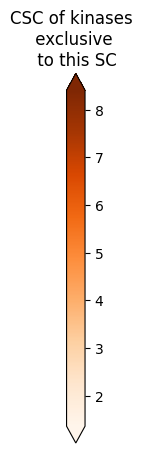

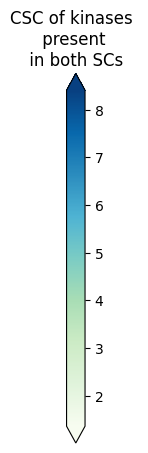

/var/folders/9d/78cj5rms6231pypdt94bp9pc0000gn/T/ipykernel_7596/1450873793.py:132: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



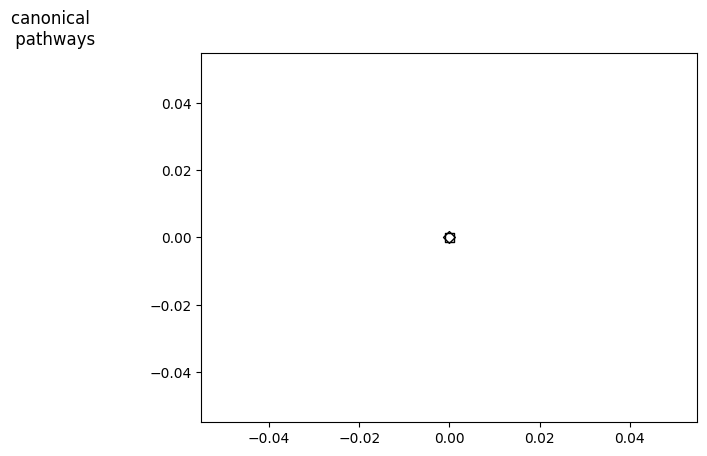

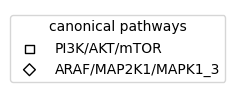

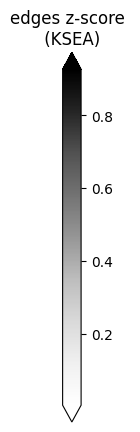

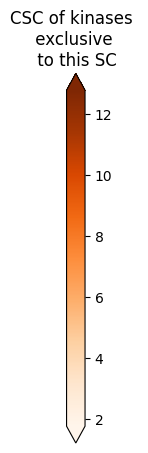

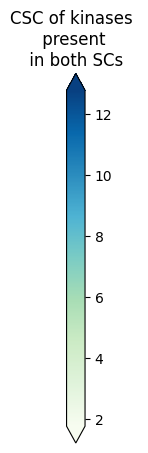

/var/folders/9d/78cj5rms6231pypdt94bp9pc0000gn/T/ipykernel_7596/1450873793.py:132: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



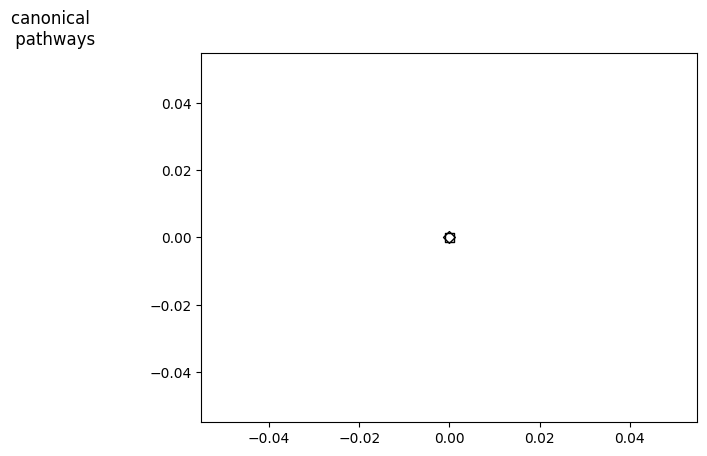

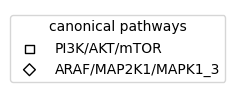

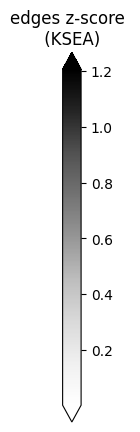

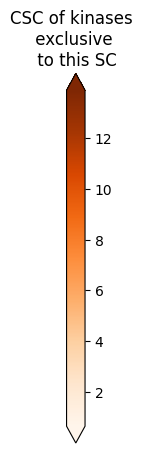

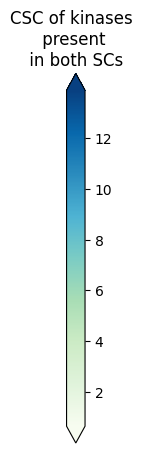

/var/folders/9d/78cj5rms6231pypdt94bp9pc0000gn/T/ipykernel_7596/1450873793.py:272: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



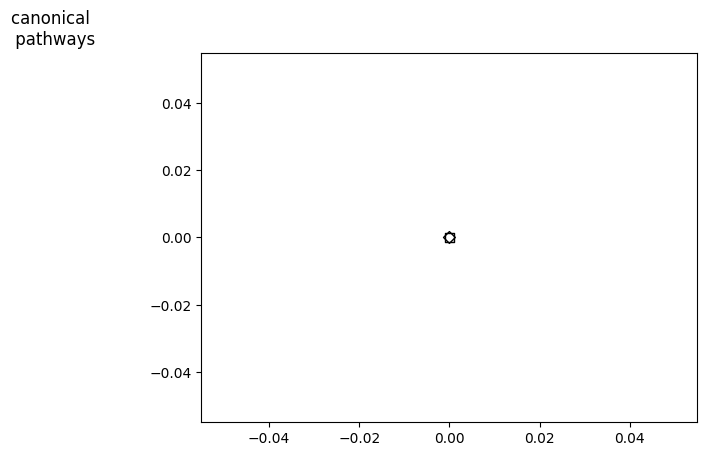

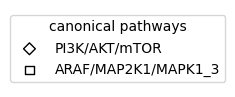

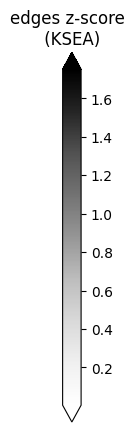

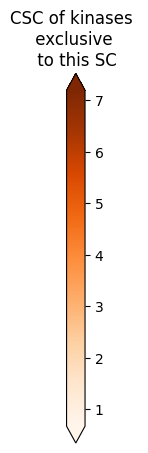

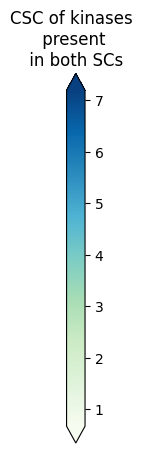

/var/folders/9d/78cj5rms6231pypdt94bp9pc0000gn/T/ipykernel_7596/1450873793.py:272: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



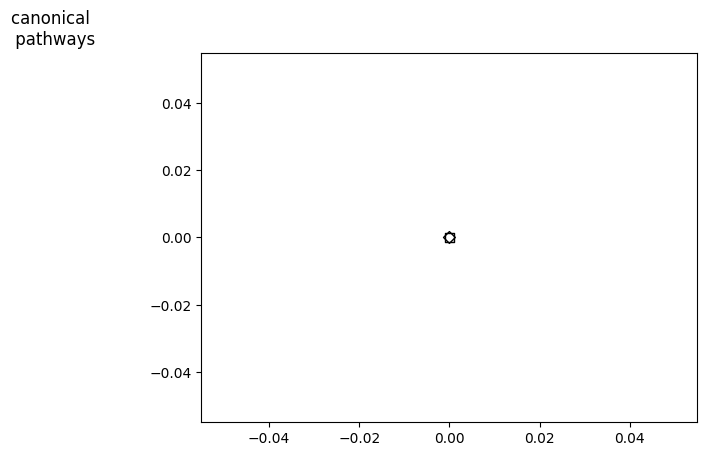

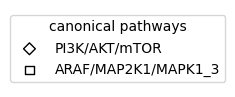

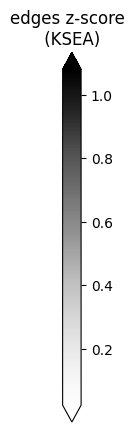

In [299]:
#https://manpages.debian.org/stretch/graphviz/dot.1.en.html

import pygraphviz
import os

com = 'MAPK14'
font_threshold = 130/255
ext= 'pdf'

#MEK_ERK
treatments = ['Trametinib', 'GDC0994']
shared_kin_nx = nx.intersection(MEK_ERK_pos_communities_nx['Trametinib'][com],MEK_ERK_pos_communities_nx['GDC0994'][com] )
nodes_inf = []
for n in range(len(treatments)):
    treat = treatments[n]
    net = MEK_ERK_pos_communities_nx[treat][com]
    #pigraphviz instance from networkx graph
    A = nx.nx_agraph.to_agraph(net)
    #Map nodes weights to colors
    color_lookup = nx.get_node_attributes(net, 'community_strength_centrality')
    min_value, *_, max_value = sorted(color_lookup.values())
    norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.GnBu) #Blues)
    other_mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)#YlOrBr)
    #Map edges weights to darker or lighter grey based on weight
    ed_color_lookup = nx.get_edge_attributes(net, 'weight')
    min_value, *_, max_value = sorted(ed_color_lookup.values())
    norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value, clip=True)
    edges_mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greys) #Blues)
    for edge in ed_color_lookup.keys():
        ed = A.get_edge(edge[0],edge[1])
        ed.attr['color'] = mcolors.to_hex(edges_mapper.to_rgba(ed_color_lookup[edge]))
        ed.attr['penwidth'] = ed_color_lookup[edge]*3
    #Draw nodes above edges
    A.graph_attr["strict"] = False
    A.graph_attr["overlap"] = False
    A.graph_attr["splines"] = 'compound'
    #Color by group
    A.node_attr['style']='filled'
    ##Nodes present in this community but not the other(s)
    unique_nodes = [node for node in list(net) if node not in shared_kin_nx]
    for node in unique_nodes:
        n = A.get_node(node)
        n.attr['fontsize'] = 22
        n.attr['fontname'] = "helvetica bold"
        #n.attr['fillcolor']="#9bd9f2"
        rgba = other_mapper.to_rgba(color_lookup[node])
        n.attr['fillcolor']= mcolors.to_hex(rgba)
        #Change font color to white if background is too dark
        if (rgba[0]*0.299 + rgba[1]*0.587 + rgba[2]*0.114) < font_threshold:
            n.attr['fontcolor']= '#ffffff'
    ##Nodes present in both communities being compared
    for node in list(shared_kin_nx):
        n = A.get_node(node)
        n.attr['fontsize'] = 22
        n.attr['fontname'] = "helvetica bold"
        #n.attr['fillcolor']="#9bd9f2"
        rgba = mapper.to_rgba(color_lookup[node])
        n.attr['fillcolor']= mcolors.to_hex(rgba)
        #Change font color to white if background is too dark
        if (rgba[0]*0.299 + rgba[1]*0.587 + rgba[2]*0.114) < font_threshold:
            n.attr['fontcolor']= '#ffffff'
    #Highlight MEK/ERK
    for node in ['ARAF','MAP2K1','MAPK1_3']:
        if node in list(net):
            n = A.get_node(node)
            n.attr['shape']='diamond'
            n.attr['width']=2
            n.attr['height']=2
            n.attr['fixedsize']='true' 
            #n.attr['penwidth']= 3
            #n.attr['color']="#FFF300"
            #n.attr['color']="#4AF1F2"
            #n.attr['fillcolor']="#9bd9f2"
            #n.attr['fillcolor']= mcolors.to_hex(mapper.to_rgba(color_lookup[node]))
    #Highlight PIK3CA/AKT
    for node in ['PIK3CA','AKT1_2','MTOR']:
        if node in list(net):
            n = A.get_node(node)
            n.attr['shape']='square'
            n.attr['width']=1.2
            n.attr['fixedsize']='true'
            #n.attr['penwidth']= 3
            #n.attr['color']="#FF6EFF"
            #n.attr['fillcolor']="#9bd9f2"
            #n.attr['fillcolor']= mcolors.to_hex(mapper.to_rgba(color_lookup[node]))
    
    ##Multi-panel colorbar
    #Boxes
    title_nodes = 'CSC of kinases (nodes)'
    title_shapes = 'canonical \n pathways'
    title_edges = 'edges z-score \n (KSEA)'
    #Suboxes
    title_shared = 'present \n in both SCs'
    title_unique = 'exclusive \n to this SC'
    
    #Add colorbar legend for unique nodes 
    fig, ax = plt.subplots(1, 1)
    fraction = 1
    plt.colorbar(other_mapper, ax=ax, pad=.05, extend='both', fraction=fraction)
    ax.axis('off')
    ax.set_title('CSC of kinases \n exclusive \n to this SC', x=-0.3)
    name = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static_unique_nodes_colorbar.{ext}"
    plt.savefig(name, bbox_inches="tight",format=f"{ext}")
    plt.show()
    
    #Add colorbar legend for shared nodes
    fig, ax = plt.subplots(1, 1)
    fraction = 1
    plt.colorbar(mapper, ax=ax, pad=.05, extend='both', fraction=fraction)
    ax.axis('off')
    ax.set_title('CSC of kinases \n present \n in both SCs', x=-0.3)
    name = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static_shared_nodes_colorbar.{ext}"
    plt.savefig(name, bbox_inches="tight",format=f"{ext}")
    plt.show()
    
    #Add shapes legend
    fig, ax = plt.subplots(1, 1)
    name = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static_shared_nodes_colorbar.pdf"
    a = ax.scatter([0], [0], marker='s', facecolors='none', edgecolors='black', label= 'PI3K/AKT/mTOR')
    b = ax.scatter([0], [0], marker='D', facecolors='none', edgecolors='black', label= 'ARAF/MAP2K1/MAPK1_3' )
    # adjust the figure size as necessary
    fig_leg = plt.figure(figsize=(1,1))
    ax_leg = fig_leg.add_subplot(111)
    # add the legend from the previous axes
    ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', title='canonical pathways')
    # hide the axes frame and the x/y labels
    ax_leg.axis('off')
    ax.set_title(title_shapes, x=-0.3)
    name = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static_pathways_legend.{ext}"
    fig_leg.savefig(name, bbox_inches="tight",format=f"{ext}")
    fig_leg.show()

    #Add colorbar legend for edges
    fig, ax = plt.subplots(1, 1)
    fraction = 1
    plt.colorbar(edges_mapper, ax=ax, pad=.05, extend='both', fraction=fraction)
    ax.axis('off')
    ax.set_title(title_edges, x=-0.3)
    name = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static_edges_colorbar.{ext}"
    plt.savefig(name, bbox_inches="tight",format=f"{ext}")
    plt.show()
    
    #Draw graph
    A.layout()
    title = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static.pdf"
    A.draw(title, prog='sfdp')

treatments = list(PI3K_AKT_pos_communities_nx.keys())
shared_kin_nx = nx.intersection(PI3K_AKT_pos_communities_nx[treatments[0]][com],PI3K_AKT_pos_communities_nx[treatments[1]][com] )
nodes_inf = []
for n in range(len(treatments)):
    treat = treatments[n]
    net = PI3K_AKT_pos_communities_nx[treat][com]
    #pigraphviz instance from networkx graph
    A = nx.nx_agraph.to_agraph(PI3K_AKT_pos_communities_nx[treatments[n]][com])
    #Map nodes weights to colors
    color_lookup = nx.get_node_attributes(net, 'community_strength_centrality')
    min_value, *_, max_value = sorted(color_lookup.values())
    norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.GnBu) #Blues)
    other_mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)#YlOrBr)
    #Map edges weights to darker or lighter grey based on weight
    ed_color_lookup = nx.get_edge_attributes(net, 'weight')
    min_value, *_, max_value = sorted(ed_color_lookup.values())
    norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value, clip=True)
    edges_mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greys) #Blues)
    for edge in ed_color_lookup.keys():
        ed = A.get_edge(edge[0],edge[1])
        ed.attr['color'] = mcolors.to_hex(edges_mapper.to_rgba(ed_color_lookup[edge]))
        ed.attr['penwidth'] = ed_color_lookup[edge]*4
    #Draw nodes above edges
    A.graph_attr["strict"] = False
    A.graph_attr["overlap"] = False
    A.graph_attr["splines"] = 'compound'
    #Color by group
    A.node_attr['style']='filled'
    ##Nodes present in this community but not the other(s)
    unique_nodes = [node for node in list(net) if node not in shared_kin_nx]
    for node in unique_nodes:
        n = A.get_node(node)
        n.attr['fontsize'] = 22
        n.attr['fontname'] = "helvetica bold"
        #n.attr['fillcolor']="#9bd9f2"
        rgba = other_mapper.to_rgba(color_lookup[node])
        n.attr['fillcolor']= mcolors.to_hex(rgba)
        #Change font color to white if background is too dark
        if (rgba[0]*0.299 + rgba[1]*0.587 + rgba[2]*0.114) < font_threshold:
            n.attr['fontcolor']= '#ffffff'
    ##Nodes present in both communities being compared
    for node in list(shared_kin_nx):
        n = A.get_node(node)
        n.attr['fontsize'] = 22
        n.attr['fontname'] = "helvetica bold"
        #n.attr['fillcolor']="#9bd9f2"
        rgba = mapper.to_rgba(color_lookup[node])
        n.attr['fillcolor']= mcolors.to_hex(rgba)
        #Change font color to white if background is too dark
        if (rgba[0]*0.299 + rgba[1]*0.587 + rgba[2]*0.114) < font_threshold:
            n.attr['fontcolor']= '#ffffff'
    #Highlight MEK/ERK
    for node in ['ARAF','MAP2K1','MAPK1_3']:
        if node in list(net):
            n = A.get_node(node)
            n.attr['shape']='square'
            n.attr['width']=1.5
            n.attr['fixedsize']='true' 
            #n.attr['penwidth']= 3
            #n.attr['color']="#FFF300"
            #n.attr['color']="#4AF1F2"
            #n.attr['fillcolor']="#9bd9f2"
            #n.attr['fillcolor']= mcolors.to_hex(mapper.to_rgba(color_lookup[node]))
    #Highlight PIK3CA/AKT
    for node in ['PIK3CA','AKT1_2','MTOR']:
        if node in list(net):
            n = A.get_node(node)
            n.attr['shape']='diamond'
            n.attr['width']=1.5
            n.attr['height']=2
            n.attr['fixedsize']='true'
            #n.attr['penwidth']= 3
            #n.attr['color']="#FF6EFF"
            #n.attr['fillcolor']="#9bd9f2"
            #n.attr['fillcolor']= mcolors.to_hex(mapper.to_rgba(color_lookup[node]))
    
    
    ##Multi-panel colorbar
    
    #Boxes
    title_nodes = 'CSC of kinases (nodes)'
    title_shapes = 'canonical \n pathways'
    title_edges = 'edges z-score \n (KSEA)'
    #Suboxes
    title_shared = 'kinases \n present \n in both SCs'
    title_unique = 'kinases \n exclusive \n to this SC'
    
    #Add colorbar legend for unique nodes 
    fig, ax = plt.subplots(1, 1)
    fraction = 1
    plt.colorbar(other_mapper, ax=ax, pad=.05, extend='both', fraction=fraction)
    ax.axis('off')
    ax.set_title('CSC of kinases \n exclusive \n to this SC', x=-0.3)
    name = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static_unique_nodes_colorbar.{ext}"
    plt.savefig(name, bbox_inches="tight",format=f"{ext}")
    plt.show()
    
    #Add colorbar legend for shared nodes
    fig, ax = plt.subplots(1, 1)
    fraction = 1
    plt.colorbar(mapper, ax=ax, pad=.05, extend='both', fraction=fraction)
    ax.axis('off')
    ax.set_title('CSC of kinases \n present \n in both SCs', x=-0.3)
    name = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static_shared_nodes_colorbar.{ext}"
    plt.savefig(name, bbox_inches="tight",format=f"{ext}")
    plt.show()
    
    #Add shapes legend
    fig, ax = plt.subplots(1, 1)
    name = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static_shared_nodes_colorbar.{ext}"
    a = ax.scatter([0], [0], marker='D', facecolors='none', edgecolors='black', label= 'PI3K/AKT/mTOR')
    b = ax.scatter([0], [0], marker='s', facecolors='none', edgecolors='black', label= 'ARAF/MAP2K1/MAPK1_3' )
    # adjust the figure size as necessary
    fig_leg = plt.figure(figsize=(1,1))
    ax_leg = fig_leg.add_subplot(111)
    # add the legend from the previous axes
    ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', title='canonical pathways')
    # hide the axes frame and the x/y labels
    ax_leg.axis('off')
    ax.set_title(title_shapes, x=-0.3)
    name = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static_pathways_legend.{ext}"
    fig_leg.savefig(name, bbox_inches="tight",format=f"{ext}")
    fig_leg.show()

    #Add colorbar legend for edges
    fig, ax = plt.subplots(1, 1)
    fraction = 1
    plt.colorbar(edges_mapper, ax=ax, pad=.05, extend='both', fraction=fraction)
    ax.axis('off')
    ax.set_title(title_edges, x=-0.3)
    name = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static_edges_colorbar.{ext}"
    plt.savefig(name, bbox_inches="tight",format=f"{ext}")
    plt.show()
    
    
    #Draw graph
    A.layout()
    title = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static"
    A.draw(f"{title}.{ext}", prog='sfdp',format=f"{ext}")
    #os.system(f"pdftoppm -png -r 300  {title}.{ext} {title}")


In [200]:
PIL.features.pilinfo()

--------------------------------------------------------------------
Pillow 9.2.0
Python 3.9.12 (main, Mar 26 2022, 15:51:13)
       [Clang 12.0.0 (clang-1200.0.32.29)]
--------------------------------------------------------------------
Python modules loaded from /usr/local/lib/python3.9/site-packages/PIL
Binary modules loaded from /usr/local/lib/python3.9/site-packages/PIL
--------------------------------------------------------------------
--- PIL CORE support ok, compiled for 9.2.0
*** TKINTER support not installed
--- FREETYPE2 support ok, loaded 2.12.1
--- LITTLECMS2 support ok, loaded 2.13.1
--- WEBP support ok, loaded 1.2.2
--- WEBP Transparency support ok
--- WEBPMUX support ok
--- WEBP Animation support ok
--- JPEG support ok, compiled for libjpeg-turbo 2.1.3
--- OPENJPEG (JPEG2000) support ok, loaded 2.5.0
--- ZLIB (PNG/ZIP) support ok, loaded 1.2.12
--- LIBTIFF support ok, loaded 4.4.0
--- RAQM (Bidirectional Text) support ok, loaded 0.9.0, fribidi 1.0.12, harfbuzz 5.3.1
**

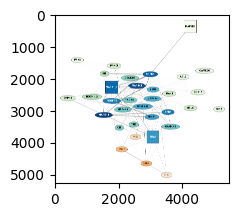

In [219]:
##Make multi-panel figure from existing figures
import PIL
from PIL import Image
#from pdf2image import convert_from_path
from PyPDF2 import PdfReader

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)

ax1_im = Image.open("output_visualizations/MAPK14.AZD5363_pos_networkviz_static-1.png")

ax1.imshow(ax1_im)

plt.savefig('output_visualizations/multiplot.pdf')



In [51]:

#Arrange communities by the kinases with the highest CSC
##Join all communities into one dictionnary for ease
all_com_pos_nx = {**MEK_ERK_pos_communities_nx, **PI3K_AKT_pos_communities_nx}
all_com_pos = {**MEK_ERK_pos_communities, **PI3K_AKT_pos_communities}
##Store kinases that were grouped alone
all_com_loners = {treat:[x[0] for x in all_communities[treat] if len(x)==1] for treat in all_com_pos.keys() }

##Make dictionnary with the kinases with the highest CSC for each community
##Remove communities of one kinase at the same time
##Note that it is returning the kinase with the highest number of edges, not with the highest CSC
all_com_pos_by_max_sc = { treat:{max(com.degree(weight='weight'))[0]:com for com in set(all_com_pos_nx[treat].values()) if len(list(com))>1 } for treat in all_com_pos_nx.keys()}

#Join pairs of networks by highest CSC kinase
MEK_ERK_com_pos_sc = join_with(list, [all_com_pos_by_max_sc['Trametinib'],all_com_pos_by_max_sc['GDC0994']])
PI3K_AKT_com_pos_sc = join_with(list, [all_com_pos_by_max_sc['GDC0941'],all_com_pos_by_max_sc['AZD5363']])
all_com_paired = [{key:value for key,value in x.items() if len(x[key])==2} for x in [MEK_ERK_com_pos_sc, PI3K_AKT_com_pos_sc] ]

#Where the highest CSC kinase does not match, find what the match is (they share at least two nodes)
unmatched = [ {k:v for k,v in x.items() if len(x[k])==1} for x in [MEK_ERK_com_pos_sc, PI3K_AKT_com_pos_sc] ]
kin_pairs = [ list(itertools.combinations(list(unmatched[0].keys()),2)) , list(itertools.combinations(list(unmatched[1].keys()),2)) ]
all_com_cs_unmatched_paired = [ {pair:[unmatched[n][pair[0]][0], unmatched[n][pair[1]][0]] for pair in kin_pairs[n] if len(list(nx.intersection(unmatched[n][pair[0]][0], unmatched[n][pair[1]][0]))) >= 2} for n in [0,1]]
##Since only one new match ...
##Remove TNK2 and PIK3CB from 2nd one
PI3K_updated = {**PI3K_AKT_com_pos_sc, **all_com_cs_unmatched_paired[1]}
del PI3K_updated['PIK3CB']
del PI3K_updated['TNK2']
all_com_results = [MEK_ERK_com_pos_sc, PI3K_updated]

#Calculate average edge weight in each community


yes_com = [ list(all_com_pos_nx[x]['YES1']) for x in all_com_pos_nx.keys() ]
yes_com_shared = set(yes_com[0]).intersection(*yes_com)

#set(p[0]).intersection(*p)

yes_com_shared

nx.get_edge_attributes(all_com_pos_nx['Trametinib']['YES1'], 'weight')

{k:v for k,v in PI3K_AKT_pos_cs['AZD5363'].items() if k in list(MEK_ERK_pos_communities_nx['Trametinib']['MAPK14'])}



NameError: name 'all_communities' is not defined

In [257]:
PI3K_AKT_pos_cs['GDC0941']['PIK3CB']

0.300371923

In [56]:
PI3K_AKT_com_kin = { key: list(x[0] for x in value if len(x)>1) for key, value in PI3K_AKT_pos_communities.items() }
MEK_ERK_com_kin = { key: list(x[0] for x in value if len(x)>1) for key, value in MEK_ERK_pos_communities.items() }

PI3K_AKT_com_kin


{'GDC0941': ['ARAF', 'STK4', 'CAMK2A', 'RPS6KA3', 'CDK2', 'CDK6', 'ULK1'],
 'AZD5363': ['ARAF',
  'CDK9',
  'CAMK2D',
  'PRKACA',
  'PIK3CA',
  'LATS1',
  'CDK2',
  'ABL1',
  'CDK4',
  'ULK1']}

In [ ]:
#Calculate average edge weight for each community
##Save identifying kinase for each of the communities with more than one member
PI3K_AKT_com_kin = { key: list(x[0] for x in value if len(x)>1) for key, value in PI3K_AKT_pos_communities.items() }
MEK_ERK_com_kin = { key: list(x[0] for x in value if len(x)>1) for key, value in MEK_ERK_pos_communities.items() }
#all_com_kin = PI3K_AKT_com_kin + MEK_ERK_com_kin
#treatments_order = list(PI3K_AKT_pos_communities.keys()) + list(MEK_ERK_pos_communities.keys())

##Calculate the average edge weight for each
MEK_ERK_pos_ave_weight = 
PI3K_AKT_pos_ave_weight = 

#Identify kinase with highest strength centrality across pair 
##Sum SC between the pair

##Find highest kinase for each




In [18]:
PI3K_AKT_pos_cs
R = G.copy()
R.remove_nodes_from(n for n in G if n not in H)
R.remove_edges_from(e for e in G.edges if e not in H.edges)

{'GDC0941': {'RPS6KA6': 0,
  'CDK7': 0,
  'AKT1_2': 0,
  'FYN': 0,
  'LIMK1_2': 0,
  'ABL1': 0,
  'MAP3K3': 0,
  'PIK3CA': 0,
  'MAPK9': 0,
  'PKN2': 0,
  'MAST1': 0,
  'RPS6KA3': 0.032836664,
  'RPS6KA4': 0.032836664,
  'ULK1': 0.094881765,
  'CLK1': 0.094881765,
  'CDK2': 0.297446508,
  'CDKL5': 0.297446508,
  'CDK6': 0,
  'DYRK2': 0,
  'CAMK2A': 0.667299105,
  'EIF2AK1': 0.552914327,
  'MAP3K15': 0.498875292,
  'STK4': 2.181380219,
  'TNK2': 0.553989976,
  'PIK3CB': 0.300371923,
  'PAK1': 1.048518228,
  'STK3': 0.591640494,
  'PAK4': 0.14494616,
  'RPS6KB1': 0.521761858,
  'ARAF': 7.134701959999998,
  'ERN1': 4.920058386999998,
  'CAMKK2': 8.549404433000001,
  'CIT': 7.989217801,
  'TAOK3': 9.028225993,
  'MAP4K5': 6.476307248999999,
  'MAPK14': 13.894565409,
  'PDGFRB': 5.928401253999999,
  'CSNK1E': 3.2805899390000004,
  'MAP3K1': 4.842367983000001,
  'MAP4K4': 5.715553156999999,
  'YES1': 5.706602831,
  'MAPK1_3': 6.964102522,
  'MINK1': 4.258963534,
  'SRPK1': 7.112985541,
  'CD

In [20]:
nx.intersection(MEK_ERK_pos_communities_nx['Trametinib']['MAPK14'],MEK_ERK_pos_communities_nx['GDC0994']['MAPK14'] )


['ERN1',
 'PAK3',
 'RPS6KA2',
 'CDK2',
 'PLK1',
 'MAPK1_3',
 'IRAK1',
 'CIT',
 'PDGFRB',
 'MAP4K5',
 'TTK',
 'TAOK3',
 'CSNK1E',
 'CAMKK2',
 'SRPK1',
 'MAP4K4',
 'YES1',
 'KIT',
 'ARAF',
 'MAPK14',
 'MAP3K1',
 'PRKCI',
 'SRPK3',
 'MAPK9',
 'ROCK1_2',
 'CDK4']

In [32]:

edges = nx.get_edge_attributes(MEK_ERK_pos_communities_nx[treatments[n]]['MAPK14'], 'weight')
from_ed = [x[0] for x in edges.keys() ]
to_ed = [x[1] for x in edges.keys() ]
edges_list = list(zip(from_ed,to_ed, edges.values(),edges.values() ))
edges_df = pd.DataFrame(edges_list, columns=['from','to','z-score','weight'])

edges_df


from       to   z-score    weight
0      ERN1     ARAF  0.570895  0.570895
1      ERN1    PRKCI  0.115927  0.115927
2      ERN1      CIT  0.224843  0.224843
3      ERN1    TAOK3  0.645144  0.645144
4      ERN1     CDK2  0.208986  0.208986
..      ...      ...       ...       ...
218  MAP3K1    SRPK3  0.288352  0.288352
219  MAP3K1    MAPK9  0.098260  0.098260
220   PRKCI  ROCK1_2  0.228103  0.228103
221   SRPK3  ROCK1_2  0.642383  0.642383
222   MAPK9     CDK4  0.718884  0.718884

[223 rows x 4 columns]

In [37]:
#MEK_ERK
treatments = ['Trametinib', 'GDC0994']
shared_kin_nx = nx.intersection(MEK_ERK_pos_communities_nx['Trametinib']['MAPK14'],MEK_ERK_pos_communities_nx['GDC0994']['MAPK14'] )
nodes_inf = []
for n in range(len(treatments)):
    #Kinases present in both
    shared_kin = list(shared_kin_nx)
    nodes_inf0 = list(zip(shared_kin, ['kinases present in both SCs']*len(shared_kin) ,  ['#FFDB33']* len(shared_kin) )) 
    
    #Kinases present in that network only
    not_shared_kin = [x for x in list(MEK_ERK_pos_communities_nx[treatments[n]]['MAPK14']) if x not in shared_kin]
    nodes_inf1 = list(zip( not_shared_kin, ['kinases present exclusively in this SC']*len(not_shared_kin) ,  ['#96efff']* len(not_shared_kin) )) 
    
    #Put together
    nodes_inf_sum = nodes_inf0 + nodes_inf1
    nodes_df = pd.DataFrame( nodes_inf_sum, columns=['id', 'group', 'color'])
    #add community strength
    kin_dict = {key:value for key,value in MEK_ERK_pos_cs[treatments[n]].items() if key in list(MEK_ERK_pos_communities_nx[treatments[n]]['MAPK14'])}
    kin_cs = list(zip(kin_dict.keys(), kin_dict.values() ))
    nodes_cs_df = pd.DataFrame (kin_cs, columns = ['id','community_strength'])
    nodes_df_add = pd.merge(nodes_df, nodes_cs_df, on='id')
    #save nodes as csv file
    nodes_df_add.to_csv('output_dataframes/MAPK14.{}_pos_nodes.csv'.format(treatments[n]))
    #save edges as csv file
    edges = nx.get_edge_attributes(MEK_ERK_pos_communities_nx[treatments[n]]['MAPK14'], 'weight')
    from_ed = [x[0] for x in edges.keys() ]
    to_ed = [x[1] for x in edges.keys() ]
    edges_list = list(zip(from_ed,to_ed, edges.values(),edges.values() ))
    edges_df = pd.DataFrame(edges_list, columns=['from','to','z-score','weight'])
    edges_df.to_csv('output_dataframes/MAPK14.{}_pos_edges.csv'.format(treatments[n]))


In [38]:
  
#PI3K_AKT
treatments = ['GDC0941', 'AZD5363']
shared_kin_nx = nx.intersection(PI3K_AKT_pos_communities_nx[treatments[0]]['MAPK14'],PI3K_AKT_pos_communities_nx[treatments[1]]['MAPK14'] )
nodes_inf = []
for n in range(len(treatments)):
    #Kinases present in both
    shared_kin = list(shared_kin_nx)
    nodes_inf0 = list(zip(shared_kin, ['kinases present in both SCs']*len(shared_kin) ,  ['#FFDB33']* len(shared_kin) )) 
    
    #Kinases present in that network only
    not_shared_kin = [x for x in list(PI3K_AKT_pos_communities_nx[treatments[n]]['MAPK14']) if x not in shared_kin]
    nodes_inf1 = list(zip( not_shared_kin, ['kinases present exclusively in this SC']*len(not_shared_kin) ,  ['#96efff']* len(not_shared_kin) )) 
    
    #Put together
    nodes_inf_sum = nodes_inf0 + nodes_inf1
    nodes_df = pd.DataFrame( nodes_inf_sum, columns=['id', 'group', 'color'])
    #add community strength
    kin_dict = {key:value for key,value in PI3K_AKT_pos_cs[treatments[n]].items() if key in list(PI3K_AKT_pos_communities_nx[treatments[n]]['MAPK14'])}
    kin_cs = list(zip(kin_dict.keys(), kin_dict.values() ))
    nodes_cs_df = pd.DataFrame (kin_cs, columns = ['id','community_strength'])
    nodes_df_add = pd.merge(nodes_df, nodes_cs_df, on='id')
    #save nodes as csv file
    nodes_df_add.to_csv('output_dataframes/MAPK14.{}_pos_nodes.csv'.format(treatments[n]))
    #save edges as csv file
    edges = nx.get_edge_attributes(PI3K_AKT_pos_communities_nx[treatments[n]]['MAPK14'], 'weight')
    from_ed = [x[0] for x in edges.keys() ]
    to_ed = [x[1] for x in edges.keys() ]
    edges_list = list(zip(from_ed,to_ed, edges.values(),edges.values() ))
    edges_df = pd.DataFrame(edges_list, columns=['from','to','z-score','weight'])
    edges_df.to_csv('output_dataframes/MAPK14.{}_pos_edges.csv'.format(treatments[n]))


# 3 - Example 2 - Analysis and Results

# Negative edges

In [247]:
#Store dataset treatments names, kinase interactions (network edges) with a z-score < 0, and their z-scores (edges weight) 
[treatments2,negative_edges2,negative_nodes2] = dataset_info('input/example2_edges_zscores.csv')
#Main kinase targets of each of the treatments/inhibitors in the dataset
targets2 = ['MTOR']

negative_edges2

{'Rapamycin_vs_Control': [('IRAK1', 'TAOK3', 0.017739734454318),
  ('CIT', 'IRAK1', 0.0176088121155252),
  ('ARAF', 'MAP4K5', 0.250856112199018),
  ('MAPK14', 'PDGFRB', 0.589465545575994),
  ('CSNK1E', 'MAP4K5', 0.134280865166933),
  ('MAP3K1', 'MAP4K5', 0.0456790845161009),
  ('MAP4K5', 'PDGFRB', 0.23851126866661),
  ('MAP4K5', 'YES1', 0.232092747425746),
  ('MAPK14', 'YES1', 0.0324736475337367),
  ('CDK9', 'CIT', 0.456588524856095),
  ('CAMKK2', 'CDK9', 0.519781281211691),
  ('CDK9', 'TAOK3', 0.594056037715994),
  ('CDK9', 'IRAK1', 0.452484060551804),
  ('SRPK1', 'SRPK3', 0.460369852688614),
  ('CDK2', 'CDK9', 0.648703952422977),
  ('ERN1', 'IRAK1', 1.12134722785229),
  ('KIT', 'MAPK14', 0.0608866520210324),
  ('KIT', 'PDGFRB', 0.0598965591746704),
  ('CDK2', 'CIT', 0.762489199791363),
  ('CAMK2D', 'CAMKK2', 0.386806186611069),
  ('ABL1', 'LIMK1_2', 0.148037016692707),
  ('CAMKK2', 'CDK2', 1.08576482909227),
  ('CDK2', 'IRAK1', 0.851027681012097),
  ('CIT', 'MAST1', 0.060915016711607

In [302]:
treatment = ['Rapamycin_vs_Control']
#Store contents of communities identified in each network
[rap_ER_communities, rap_ER_communities_nx, rap_ER_cs] = converge_asso(edges_dict=negative_edges2, sel_treatments=treatment)
#Reproducibiliyyt check
treatment = 'Rapamycin_vs_Control'
target = 'MTOR'
#[rap_ER_communities[treatment], rap_ER_communities_nx[treatment], rap_ER_cs[treatment]] = rep_check(n_checks=50,edges_dict=negative_edges2,treatment=treatment,target=target)

In [174]:

print(rap_ER_communities_nx['Rapamycin_vs_Control']['MAP2K1'].nodes() )

[x for x in negative_edges2[treatment] if x[0] == 'MAP2K1' or x[1] == 'MAP2K1']


['MAP2K1', 'PIK3CB']


[('MAP2K1', 'PIK3CA', 1.24381833932769),
 ('MAP2K1', 'MAP3K1', 0.391478923039941),
 ('MAP2K1', 'MAP4K5', 0.505397116441636)]

In [162]:
print(rap_ER_communities['Rapamycin_vs_Control'])
print({key:value for key,value in rap_ER_cs['Rapamycin_vs_Control'].items() if key in list(rap_ER_communities_nx['Rapamycin_vs_Control']['MTOR'])})

rap_ER_communities_nx['Rapamycin_vs_Control']['MTOR'].edges('TTK')

print({k:v for k,v in nx.get_edge_attributes(rap_ER_communities_nx['Rapamycin_vs_Control']['MTOR'],'weight').items() if 'TTK' in k} )

print({k:v for k,v in nx.get_edge_attributes(rap_ER_communities_nx['Rapamycin_vs_Control']['MAP2K1'],'weight').items() in k} )


[['IRAK1', 'TAOK3', 'CIT', 'ARAF', 'MAP4K5', 'MAPK14', 'CSNK1E', 'MAP3K1', 'YES1', 'CDK9', 'CAMKK2', 'CDK2', 'ERN1', 'KIT', 'CAMK2D', 'CDK6', 'CDK4', 'PLK1', 'CAMK2G', 'PAK1', 'PAK2', 'MAP4K4', 'CDK1', 'CDK5', 'ULK1', 'EIF2AK1', 'CDK17', 'CDKL5'], ['ROCK1_2', 'SRPK3', 'TNK2', 'ABL1', 'LIMK1_2', 'PDGFRB', 'TTK', 'PAK3', 'SRPK1', 'AKT1_2', 'MTOR', 'MAPK1_3'], ['STK4', 'MAP3K3', 'RPS6KA3', 'PRKACA'], ['PRKCI', 'CAMK2A', 'RPS6KA4'], ['MAST1', 'BMP2K'], ['RPS6KA2', 'STK3'], ['LATS1', 'MARK3'], ['PIK3CB', 'MAP2K1'], ['CSNK2A2', 'PHKG2'], ['MAPK9'], ['FYN'], ['PAK4'], ['MELK']]
{'PDGFRB': 2.220713361430863, 'SRPK1': 4.583286240044415, 'SRPK3': 8.557819411317208, 'ABL1': 7.439280589692665, 'LIMK1_2': 3.6494411736818826, 'TTK': 23.218393335783933, 'TNK2': 6.271310956365911, 'MAPK1_3': 8.626203429024802, 'PAK3': 4.691622968894911, 'MTOR': 9.83329310785424, 'AKT1_2': 6.636271167600205, 'ROCK1_2': 1.88933041657807}
{('ROCK1_2', 'TTK'): 1.88933041657807, ('SRPK3', 'TTK'): 0.706648912669096, ('ABL1'

TypeError: 'in <string>' requires string as left operand, not dict_items

In [239]:
PI3K_AKT_communities_nx

{'AZD5363': {'MAPK9': <networkx.classes.graph.Graph at 0x13d43ca60>,
  'MELK': <networkx.classes.graph.Graph at 0x13d43c820>,
  'CDK17': <networkx.classes.graph.Graph at 0x13d43c790>,
  'PKN2': <networkx.classes.graph.Graph at 0x13d43c6d0>,
  'SIK2': <networkx.classes.graph.Graph at 0x13c658040>,
  'CDK4': <networkx.classes.graph.Graph at 0x13c6580d0>,
  'MAP3K3': <networkx.classes.graph.Graph at 0x13c470e20>,
  'PDGFRB': <networkx.classes.graph.Graph at 0x133702340>,
  'MAP2K1': <networkx.classes.graph.Graph at 0x133702340>,
  'ROCK1_2': <networkx.classes.graph.Graph at 0x13ddc27f0>,
  'MARK3': <networkx.classes.graph.Graph at 0x13ddc27f0>,
  'ABL2': <networkx.classes.graph.Graph at 0x13d01c2e0>,
  'FYN': <networkx.classes.graph.Graph at 0x13d01c2e0>,
  'ARAF': <networkx.classes.graph.Graph at 0x138233c70>,
  'SRPK3': <networkx.classes.graph.Graph at 0x138233c70>,
  'MAP4K4': <networkx.classes.graph.Graph at 0x138233c70>,
  'KIT': <networkx.classes.graph.Graph at 0x138233c70>,
  'YES1

In [303]:
treatments = list(PI3K_AKT_pos_communities_nx.keys())
PI3K_AKT_shared = nx.intersection(PI3K_AKT_communities_nx[treatments[0]]['PIK3CA'],PI3K_AKT_communities_nx[treatments[1]]['AKT1_2'] )
shared_kin_nx = nx.intersection(rap_ER_communities_nx['Rapamycin_vs_Control']['MTOR'], PI3K_AKT_shared)
#Also shared with either MAP2K1 or MAPK1_3
MEK_ERK = nx.intersection(MEK_ERK_communities_nx['Trametinib']['MAP2K1'], MEK_ERK_communities_nx['GDC0994']['MAPK1_3'])
MEK_ERK_shared = nx.intersection(rap_ER_communities_nx['Rapamycin_vs_Control']['MTOR'], MEK_ERK)

list(MEK_ERK_shared)


['MAPK1_3', 'TNK2', 'PDGFRB']

In [315]:


PI3K_AKT_int = [('Rapamycin_vs_Control','MTOR','-'), ('GDC0941','PIK3CA','-'),('AZD5363','AKT1_2','-')]
sup_st = '$^{'
sup_end = '}$'
sub_st = '$_{'
sub_end = '}$'
PI3K_AKT_names = [ f"{x[0]}{sup_st}{x[2]}{sup_end}{sub_st}({x[1]}){sub_end}" for x in PI3K_AKT_int]

MEK_ERK_int = [('Rapamycin_vs_Control','MTOR','-'), ('trametinib','MAP2K1','-'),('GDC0994','MAPK1_3','-')]
MEK_ERK_names = [ f"{x[0]}{sup_st}{x[2]}{sup_end}{sub_st}({x[1]}){sub_end}" for x in MEK_ERK_int]

MEK_ERK_names


['Rapamycin_vs_Control$^{-}$$_{(MTOR)}$',
 'trametinib$^{-}$$_{(MAP2K1)}$',
 'GDC0994$^{-}$$_{(MAPK1_3)}$']

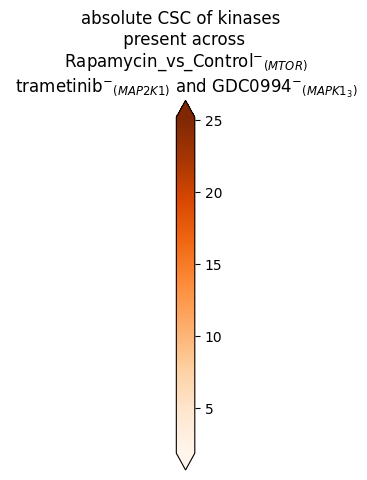

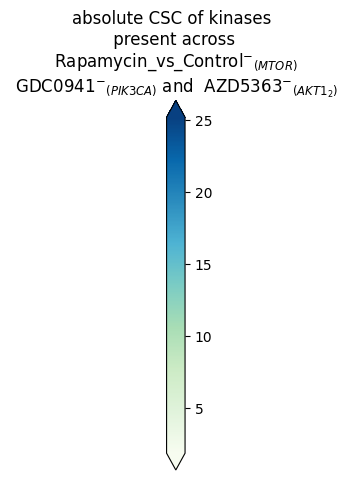

/var/folders/9d/78cj5rms6231pypdt94bp9pc0000gn/T/ipykernel_7596/2014737422.py:124: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



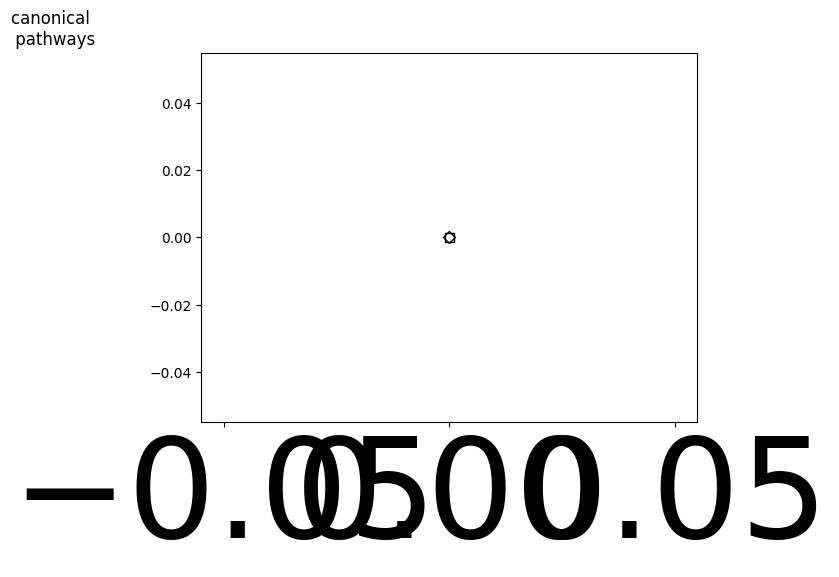

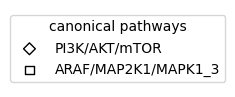

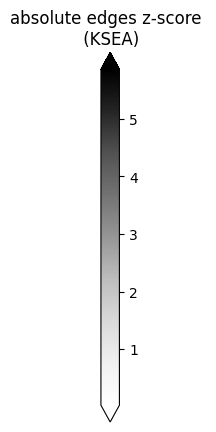

In [371]:
##Graph visualization

treatments = ['Rapamycin_vs_Control']
com = 'MTOR'
treat = 'MCF7_AML_com_comparisson'
ext='pdf'
for n in range(len(treatments)):
    net = rap_ER_communities_nx[treatments[n]][com]
    #pigraphviz instance from networkx graph
    A = nx.nx_agraph.to_agraph(net)
    #Map nodes weights to colors
    color_lookup = nx.get_node_attributes(net, 'community_strength_centrality')
    min_value, *_, max_value = sorted(color_lookup.values())
    norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.GnBu) #Blues)
    other_mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Oranges)#YlOrBr)
    #Map edges weights to darker or lighter grey based on weight
    ed_color_lookup = nx.get_edge_attributes(net, 'weight')
    min_value, *_, max_value = sorted(ed_color_lookup.values())
    norm = mpl.colors.Normalize(vmin=min_value, vmax=max_value, clip=True)
    edges_mapper = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.Greys) #Blues)
    for edge in ed_color_lookup.keys():
        ed = A.get_edge(edge[0],edge[1])
        ed.attr['color'] = mcolors.to_hex(edges_mapper.to_rgba(ed_color_lookup[edge]))
        ed.attr['penwidth'] = ed_color_lookup[edge]*1
    #Draw nodes above edges
    A.graph_attr["strict"] = False
    A.graph_attr["overlap"] = False
    A.graph_attr["splines"] = 'compound'
    #Color by group
    A.node_attr['style']='filled'
    ##Nodes present in this community but not the other(s)
    #unique_nodes = [node for node in list(net) if node not in shared_kin_nx]
    for node in list(MEK_ERK_shared):
        n = A.get_node(node)
        n.attr['fontsize'] = 22
        n.attr['fontname'] = "helvetica bold"
        #n.attr['fillcolor']="#9bd9f2"
        rgba = other_mapper.to_rgba(color_lookup[node])
        n.attr['fillcolor']= mcolors.to_hex(rgba)
        #Change font color to white if background is too dark
        if (rgba[0]*0.299 + rgba[1]*0.587 + rgba[2]*0.114) < font_threshold:
            n.attr['fontcolor']= '#ffffff'
    ##Nodes present in both communities being compared
    for node in list(shared_kin_nx):
        n = A.get_node(node)
        n.attr['fontsize'] = 22
        n.attr['fontname'] = "helvetica bold"
        #n.attr['fillcolor']="#9bd9f2"
        rgba = mapper.to_rgba(color_lookup[node])
        n.attr['fillcolor']= mcolors.to_hex(rgba)
        #Change font color to white if background is too dark
        if (rgba[0]*0.299 + rgba[1]*0.587 + rgba[2]*0.114) < font_threshold:
            n.attr['fontcolor']= '#ffffff'
    for node in list(net):
        if node not in list(MEK_ERK_shared) and node not in list(shared_kin_nx):
            n = A.get_node(node)
            n.attr['fontsize'] = 22
            n.attr['fontname'] = "helvetica bold"
            
    #Highlight MEK/ERK
    for node in ['ARAF','MAP2K1','MAPK1_3']:
        if node in list(net):
            n = A.get_node(node)
            n.attr['shape']='square'
            n.attr['width']=1.5
            n.attr['fixedsize']='true' 
            #n.attr['penwidth']= 3
            #n.attr['color']="#FFF300"
            #n.attr['color']="#4AF1F2"
            #n.attr['fillcolor']="#9bd9f2"
            #n.attr['fillcolor']= mcolors.to_hex(mapper.to_rgba(color_lookup[node]))
    #Highlight PIK3CA/AKT
    for node in ['PIK3CA','AKT1_2','MTOR']:
        if node in list(net):
            n = A.get_node(node)
            n.attr['shape']='diamond'
            n.attr['width']=1.5
            n.attr['height']=2
            n.attr['fixedsize']='true'
            #n.attr['penwidth']= 3
            #n.attr['color']="#FF6EFF"
            #n.attr['fillcolor']="#9bd9f2"
            #n.attr['fillcolor']= mcolors.to_hex(mapper.to_rgba(color_lookup[node]))
    
    
    ##Multi-panel colorbar
        
    #Add colorbar legend for unique nodes 
    fig, ax = plt.subplots(1, 1)
    fraction = 1
    plt.colorbar(other_mapper, ax=ax, pad=.05, extend='both', fraction=fraction)
    ax.axis('off')
    ax.set_title(f"absolute CSC of kinases \n present across \n {MEK_ERK_names[0]} \n {MEK_ERK_names[1]} and {MEK_ERK_names[2]}", x=-0.3)
    name = f"output_visualizations/{treat}_pos_networkviz_static_unique_nodes_colorbar.{ext}"
    plt.savefig(name, bbox_inches="tight",format=f"{ext}")
    plt.show()
    
    #Add colorbar legend for shared nodes
    fig, ax = plt.subplots(1, 1)
    fraction = 1
    plt.colorbar(mapper, ax=ax, pad=.05, extend='both', fraction=fraction)
    ax.axis('off')
    ax.set_title(f"absolute CSC of kinases \n present across \n {PI3K_AKT_names[0]} \n {PI3K_AKT_names[1]} and  {PI3K_AKT_names[2]}", x=-0.3)
    name = f"output_visualizations/{treat}_pos_networkviz_static_shared_nodes_colorbar.{ext}"
    plt.savefig(name, bbox_inches="tight",format=f"{ext}")
    plt.show()
    
    #Add shapes legend
    fig, ax = plt.subplots(1, 1)
    name = f"output_visualizations/MAPK14.{treat}_pos_networkviz_static_shared_nodes_colorbar.{ext}"
    a = ax.scatter([0], [0], marker='D', facecolors='none', edgecolors='black', label= 'PI3K/AKT/mTOR')
    b = ax.scatter([0], [0], marker='s', facecolors='none', edgecolors='black', label= 'ARAF/MAP2K1/MAPK1_3' )
    # adjust the figure size as necessary
    fig_leg = plt.figure(figsize=(1,1))
    ax_leg = fig_leg.add_subplot(111)
    # add the legend from the previous axes
    ax_leg.legend(*ax.get_legend_handles_labels(), loc='center', title='canonical pathways')
    # hide the axes frame and the x/y labels
    ax_leg.axis('off')
    ax.set_title(title_shapes, x=-0.3)
    name = f"output_visualizations/{treat}_pos_networkviz_static_pathways_legend.{ext}"
    fig_leg.savefig(name, bbox_inches="tight",format=f"{ext}")
    fig_leg.show()

    #Add colorbar legend for edges
    fig, ax = plt.subplots(1, 1)
    fraction = 1
    plt.colorbar(edges_mapper, ax=ax, pad=.05, extend='both', fraction=fraction)
    ax.axis('off')
    ax.set_title('absolute edges z-score \n (KSEA)', x=-0.3)
    name = f"output_visualizations/{treat}_pos_networkviz_static_edges_colorbar.{ext}"
    plt.savefig(name, bbox_inches="tight",format=f"{ext}")
    plt.show()
    
    
    #Draw graph
    A.layout()
    title = f"output_visualizations/{treat}_pos_networkviz_static"
    A.draw(f"{title}.{ext}", prog='sfdp',format=f"{ext}")
    #os.system(f"pdftoppm -png -r 300  {title}.{ext} {title}")


In [290]:
all_com

{'GDC0941': {'ABL1': <networkx.classes.graph.Graph at 0x13475c130>,
  'LIMK1_2': <networkx.classes.graph.Graph at 0x13475c130>,
  'PAK3': <networkx.classes.graph.Graph at 0x13475c130>,
  'PIK3CA': <networkx.classes.graph.Graph at 0x13475c130>,
  'TTK': <networkx.classes.graph.Graph at 0x13475c130>,
  'TNK2': <networkx.classes.graph.Graph at 0x13475c130>,
  'MINK1': <networkx.classes.graph.Graph at 0x13475c130>,
  'SRPK1': <networkx.classes.graph.Graph at 0x13475c130>,
  'MTOR': <networkx.classes.graph.Graph at 0x13475c130>,
  'AKT1_2': <networkx.classes.graph.Graph at 0x13475c130>},
 'AZD5363': {'MINK1': <networkx.classes.graph.Graph at 0x133e1cd00>,
  'SRPK1': <networkx.classes.graph.Graph at 0x133e1cd00>,
  'ABL1': <networkx.classes.graph.Graph at 0x133e1cd00>,
  'LIMK1_2': <networkx.classes.graph.Graph at 0x133e1cd00>,
  'PAK3': <networkx.classes.graph.Graph at 0x133e1cd00>,
  'TTK': <networkx.classes.graph.Graph at 0x133e1cd00>,
  'PIK3CA': <networkx.classes.graph.Graph at 0x133e1c

In [367]:
import plotly.io as pio
import kaleido
## Comparative heatmap

#Combine dictionnaries
all_com = dict(ChainMap(*[rap_ER_communities_nx, PI3K_AKT_communities_nx]))
all_com_cs = dict(ChainMap(*[rap_ER_cs, PI3K_AKT_cs]))
for net in all_com.keys():
    all_com[net] = {kin:all_com[net][kin] for kin in all_com[net].keys() if kin in shared_kin_nx}
    all_com_cs[net] = {kin:all_com_cs[net][kin] for kin in all_com_cs[net].keys() if kin in shared_kin_nx}

#Figure
all_com['Rapamycin'] = all_com.pop('Rapamycin_vs_Control')
all_com_cs['Rapamycin'] = all_com_cs.pop('Rapamycin_vs_Control')
com_int = [('Rapamycin','MTOR','-'), ('GDC0941','PIK3CA','-'),('AZD5363','AKT1_2','-')]

fig = cs_comparisson(communities_nx=all_com, communities_cs=all_com_cs, treatment_targets_sign=com_int, kin_int=shared_kin_nx, position=0)
#fig1 = fig.gcf()
#fig.write_image(file='output_visualizations/MCF7_AML_com_comparisson.pdf', format='pdf', engine='kaleido')
fig.update_layout(
    font=dict(
        size=16,
    )
)
fig.show()





# Positive edges

In [105]:
#Store dataset treatments names, kinase interactions (network edges) with a z-score < 0, and their z-scores (edges weight) 
[treatments2,positive_edges2, positive_nodes2] = dataset_info('input/example2_edges_zscores.csv', sign='pos')


In [106]:
treatment = ['Rapamycin_vs_Control']
#Store contents of communities identified in each network
[rap_ER_pos_communities, rap_ER_pos_communities_nx, rap_ER_pos_cs] = converge_asso(edges_dict=positive_edges2, sel_treatments=treatment)
#Reproducibiliyyt check
treatment = 'Rapamycin_vs_Control'

rap_ER_pos_communities['Rapamycin_vs_Control']

[['ARAF',
  'CAMKK2',
  'CIT',
  'TAOK3',
  'IRAK1',
  'MAP4K5',
  'MINK1',
  'SRPK1',
  'RPS6KA2',
  'CAMK2A',
  'CDK9',
  'DYRK2',
  'PHKG2',
  'PAK4',
  'MAP3K15',
  'CDKL5',
  'MELK',
  'CLK1',
  'MARK3',
  'AURKB',
  'CLK2',
  'MAP3K3'],
 ['ERN1',
  'PDGFRB',
  'MAPK1_3',
  'PRKCI',
  'PLK1',
  'TNK2',
  'AKT1_2',
  'PIK3CA',
  'MAP2K1',
  'STK3',
  'SRPK3',
  'MTOR',
  'STK4',
  'HIPK3',
  'CDK4',
  'MAPKAPK2',
  'RPS6KB1'],
 ['CDK2',
  'CSNK1E',
  'MAPK14',
  'PAK1',
  'MAPK9',
  'PIK3CB',
  'LIMK1_2',
  'PRKACA',
  'LATS1',
  'ROCK1_2',
  'RPS6KA3',
  'ABL2',
  'ABL1',
  'PRKACB',
  'CAMK2G',
  'RPS6KA4'],
 ['MAP3K1', 'MAP4K4', 'YES1', 'KIT', 'PAK3', 'TTK'],
 ['CDK1', 'CDK5', 'CAMK2D', 'CDK6'],
 ['CSNK2A2', 'MAST1'],
 ['FYN', 'ULK1'],
 ['TAOK1'],
 ['PAK2'],
 ['MAP3K2']]

In [232]:
rap_ER_pos_communities_nx['Rapamycin_vs_Control']['LATS1'].nodes()
#print({k:v for k,v in rap_ER_pos_cs['Rapamycin_vs_Control'].items() if k in list(rap_ER_pos_communities_nx['Rapamycin_vs_Control']['LATS1'])})

#print({k:v for k,v in nx.get_edge_attributes(rap_ER_pos_communities_nx['Rapamycin_vs_Control']['CAMKK2'],'weight').items() if 'CAMKK2' in k} )

#pos=nx.spring_layout(rap_ER_pos_communities_nx['Rapamycin_vs_Control']['LATS1'])
#G=rap_ER_pos_communities_nx['Rapamycin_vs_Control']['LATS1']
# nodes
#nx.draw_networkx_nodes(G, pos, node_size=700)
#nx.draw_networkx_labels(G, pos, font_size=8, font_family="sans-serif")
# edges
#nx.draw_networkx_edges(G, pos, edgelist=G.edges(), width=3)
#edge_labels = nx.get_edge_attributes(G, "weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels)

# graph
#ax = plt.gca()
#ax.margins(0.08)
#plt.axis("off")
#plt.tight_layout()
#plt.show

dicti = rap_ER_pos_communities_nx['Rapamycin_vs_Control']
rap_ER_pos_cs_ave = { k:( v/len(dicti[k].edges(k)) ) for k,v in rap_ER_pos_cs['Rapamycin_vs_Control'].items() if len(dicti[k].edges(k)) != 0}
#print({k:(v/(len(dicti[k].edges()))) for k,v in rap_ER_pos_cs.items()})


rap_ER_pos_cs_all = join_with(tuple, [rap_ER_pos_cs['Rapamycin_vs_Control'],rap_ER_pos_cs_ave ])

rap_ER_pos_cs_all

dicti['CDK2'].nodes()


NodeView(('ARAF', 'CAMKK2', 'CIT', 'TAOK3', 'IRAK1', 'CDK2', 'CSNK1E', 'MAP4K5', 'MAPK14', 'MINK1', 'SRPK1', 'PAK1', 'MAPK9', 'RPS6KA2', 'PIK3CB', 'CAMK2A', 'CDK9', 'DYRK2', 'PHKG2', 'LIMK1_2', 'PRKACA', 'PAK4', 'MAP3K15', 'LATS1', 'CDKL5', 'ROCK1_2', 'RPS6KA3', 'ABL2', 'ABL1', 'MELK', 'PRKACB', 'CAMK2G', 'RPS6KA4', 'CLK1', 'MARK3', 'AURKB', 'CLK2', 'MAP3K3'))

In [196]:
nx.get_edge_attributes(rap_ER_pos_communities_nx['Rapamycin_vs_Control']['MTOR'], 'weight' )
print(rap_ER_pos_cs['Rapamycin_vs_Control'])
print('POSITIVE')
print({k:v for k,v in nx.get_edge_attributes(rap_ER_pos_communities_nx['Rapamycin_vs_Control']['MTOR'],'weight').items() if 'MTOR' in k} )
print(rap_ER_pos_cs['Rapamycin_vs_Control']['MTOR'])
print({k:v for k,v in nx.get_edge_attributes(rap_ER_pos_communities_nx['Rapamycin_vs_Control']['AKT1_2'],'weight').items() if 'AKT1_2' in k} )
print(rap_ER_pos_cs['Rapamycin_vs_Control']['AKT1_2'])
print({k:v for k,v in nx.get_edge_attributes(rap_ER_pos_communities_nx['Rapamycin_vs_Control']['PIK3CA'],'weight').items() if 'PIK3CA' in k } )
print(rap_ER_pos_cs['Rapamycin_vs_Control']['PIK3CA'])
print('NEGATIVE')
print({k:v for k,v in nx.get_edge_attributes(rap_ER_communities_nx['Rapamycin_vs_Control']['MTOR'],'weight').items() if 'MTOR' in k} )
print(rap_ER_cs['Rapamycin_vs_Control']['MTOR'])
print({k:v for k,v in nx.get_edge_attributes(rap_ER_communities_nx['Rapamycin_vs_Control']['MTOR'],'weight').items() if 'AKT1_2' in k} )
print(rap_ER_cs['Rapamycin_vs_Control']['AKT1_2'])
print({k:v for k,v in nx.get_edge_attributes(rap_ER_communities_nx['Rapamycin_vs_Control']['PIK3CA'],'weight').items() if 'PIK3CA' in k } )
print(rap_ER_cs['Rapamycin_vs_Control']['PIK3CA'])

print('resistance mechanism?')
print({k:v for k,v in nx.get_edge_attributes(rap_ER_pos_communities_nx['Rapamycin_vs_Control']['MTOR'],'weight').items() if 'STK3' in k} )
print(rap_ER_pos_cs['Rapamycin_vs_Control']['STK3'])
print({k:v for k,v in nx.get_edge_attributes(rap_ER_pos_communities_nx['Rapamycin_vs_Control']['MTOR'],'weight').items() if 'STK4' in k} )
print(rap_ER_pos_cs['Rapamycin_vs_Control']['STK4'])


POSITIVE
{('STK4', 'MTOR'): 1.38214235588134, ('TNK2', 'MTOR'): 0.600501881387683, ('AKT1_2', 'MTOR'): 0.91728177547415, ('PRKCI', 'MTOR'): 1.14468018409453}
4.044606196837703
{('STK4', 'AKT1_2'): 1.25600267834592, ('RPS6KB1', 'AKT1_2'): 0.600501881387683, ('TNK2', 'AKT1_2'): 1.1263527062226, ('PLK1', 'AKT1_2'): 0.731429087732607, ('STK3', 'AKT1_2'): 1.38214235588134, ('AKT1_2', 'PIK3CA'): 0.449614803027167, ('AKT1_2', 'MTOR'): 0.91728177547415, ('AKT1_2', 'PRKCI'): 0.749875517479701}
7.213200805551168
{('PDGFRB', 'PIK3CA'): 1.25310824629837, ('STK3', 'PIK3CA'): 1.38214235588134, ('AKT1_2', 'PIK3CA'): 0.449614803027167, ('PIK3CA', 'PRKCI'): 0.635088341341484, ('PIK3CA', 'MAPK1_3'): 1.25310824629837}
4.973061992846731
NEGATIVE
{('SRPK3', 'MTOR'): 2.51420367231092, ('ABL1', 'MTOR'): 1.81072724526663, ('TTK', 'MTOR'): 3.69763494501006, ('SRPK1', 'MTOR'): 1.81072724526663, ('PIK3CA', 'MTOR'): 1.86722175444314}
11.70051486229738
{('SRPK3', 'AKT1_2'): 2.32840372330546, ('TTK', 'AKT1_2'): 2.9

# Comparisson of MTOR community in negative and positive edges

In [154]:
neg_pos_target_communities = [target_communities2, pos_target_communities2[0]]

neg_pos_target_communities 

In [ ]:
[x1,y1,z1] = cs_calculation(treat_int=[0,1], communities=neg_pos_target_communities, treatments=community_names)

# HEATMAP
fig = go.Figure(data=go.Heatmap(
                z=z1,
                x=x1,
                y=y1,
                hoverongaps = False))
fig.show()